# <center> Unsupervised Community Segmentation in E-commerce </center>
## <center> Leveraging Clustering Techniques for Customer Insights </center>

__Problem Statement:__
The goal of this project is to segment customers of an e-commerce platform into distinct communities based on their purchasing behavior without any prior labels in the dataset. The objective is to gain insights into customer segmentation to inform marketing strategies, product recommendations, and customer service approaches. By utilizing unsupervised learning techniques such as clustering, specifically K-Means, Hierarchical clustering and Guassian Mixture Model Clustering, the goal is to partition the dataset into meaningful clusters that represent different customer segments. Through this analysis, we aim to provide actionable insights for the e-commerce platform to enhance customer engagement and satisfaction. <br>
Reference: https://www.kaggle.com/datasets/carrie1/ecommerce-data

__Dataset Columns:__
The dataset comprises transactional data from an e-commerce platform.
1. InvoiceNo: A unique identifier for each transaction or invoice. Code starting with 'c' indicates Cancellation.
2. StockCode: A unique identifier for each product or item in the inventory.
3. Description: A brief description of the product or item.
4. Quantity: The quantity of each product purchased in a transaction.
5. InvoiceDate: The date and time when the transaction occurred.
6. UnitPrice: The price of each unit of the product.
7. CustomerID: A unique identifier for each customer.
8. Country: The country where the transaction took place.

In [131]:
# Import required libraries and setup
# import sys
# !conda install --yes --prefix {sys.prefix} plotly
# !conda install --yes --prefix {sys.prefix} wordcloud

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import string
import nltk
import matplotlib.cm as cm
import numpy as np
import scipy.cluster.hierarchy as sch

from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from math import pi
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

nltk.download('stopwords')

pd.set_option('display.max_columns', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manjaripokala/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [132]:
# Load the dataset
# Treating Customer IDs as strings as they are identifiers
df = pd.read_csv('data.csv', encoding="ISO-8859-1", dtype={'CustomerID': str})
print(df.shape)

(541909, 8)


## <center> 1. Explore Dataset Information </center>

In [133]:
# Display information about the dataset (e.g., column names, data types, non-null counts)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [134]:
# Display the first few rows of the dataset
print("First few rows of the dataset:")
df.head()
# df[df['CustomerID'] == '15311'].head(10)

First few rows of the dataset:


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice CustomerID         Country  
0  12/1/2010 8:26       2.55      17850  United Kingdom  
1  12/1/2010 8:26       3.39      17850  United Kingdom  
2  12/1/2010 8:26       2.75      17850  United Kingdom  
3  12/1/2010 8:26       3.39      17850  United Kingdom  
4  12/1/2010 8:26       3.39      17850  United Kingdom

In [135]:
# Display summary statistics of numerical columns
print("\nSummary statistics:")
df.describe().T


Summary statistics:


count      mean         std       min   25%   50%    75%  \
Quantity   541909.0  9.552250  218.081158 -80995.00  1.00  3.00  10.00   
UnitPrice  541909.0  4.611114   96.759853 -11062.06  1.25  2.08   4.13   

               max  
Quantity   80995.0  
UnitPrice  38970.0

In [136]:
# Display summary statistics of non-numerical columns
df.describe(include='object').T

count unique                                 top    freq
InvoiceNo    541909  25900                              573585    1114
StockCode    541909   4070                              85123A    2313
Description  540455   4223  WHITE HANGING HEART T-LIGHT HOLDER    2369
InvoiceDate  541909  23260                    10/31/2011 14:41    1114
CustomerID   406829   4372                               17841    7983
Country      541909     38                      United Kingdom  495478

In [137]:
min_date = pd.to_datetime(df['InvoiceDate']).min()
max_date = pd.to_datetime(df['InvoiceDate']).max()

# Calculate the span of the data
date_span = max_date - min_date

print(f"Minimum Date: {min_date}")
print(f"Maximum Date: {max_date}")
print(f"Span of Data: {date_span}")

Minimum Date: 2010-12-01 08:26:00
Maximum Date: 2011-12-09 12:50:00
Span of Data: 373 days 04:24:00


In [138]:
df[df['Quantity'] == 80995.0]

InvoiceNo StockCode                  Description  Quantity  \
540421    581483     23843  PAPER CRAFT , LITTLE BIRDIE     80995   

           InvoiceDate  UnitPrice CustomerID         Country  
540421  12/9/2011 9:15       2.08      16446  United Kingdom

In [139]:
df[(df['UnitPrice'] == 38970.0) | (df['UnitPrice'] == -11062.06)]

InvoiceNo StockCode      Description  Quantity      InvoiceDate  \
222681   C556445         M           Manual        -1  6/10/2011 15:31   
299983   A563186         B  Adjust bad debt         1  8/12/2011 14:51   
299984   A563187         B  Adjust bad debt         1  8/12/2011 14:52   

        UnitPrice CustomerID         Country  
222681   38970.00      15098  United Kingdom  
299983  -11062.06        NaN  United Kingdom  
299984  -11062.06        NaN  United Kingdom

## 1.1 Categorical Unique values

In [140]:
# Check unique values in categorical columns
print("\nUnique values in categorical columns:")
for column in df.select_dtypes(include=['object']).columns:
    print(column + ":")
    print(df[column].unique())


Unique values in categorical columns:
InvoiceNo:
['536365' '536366' '536367' ... '581585' '581586' '581587']
StockCode:
['85123A' '71053' '84406B' ... '90214U' '47591b' '23843']
Description:
['WHITE HANGING HEART T-LIGHT HOLDER' 'WHITE METAL LANTERN'
 'CREAM CUPID HEARTS COAT HANGER' ... 'lost'
 'CREAM HANGING HEART T-LIGHT HOLDER' 'PAPER CRAFT , LITTLE BIRDIE']
InvoiceDate:
['12/1/2010 8:26' '12/1/2010 8:28' '12/1/2010 8:34' ... '12/9/2011 12:31'
 '12/9/2011 12:49' '12/9/2011 12:50']
CustomerID:
['17850' '13047' '12583' ... '13298' '14569' '12713']
Country:
['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Bahrain' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'RSA']


## 1.2 Orders By Country

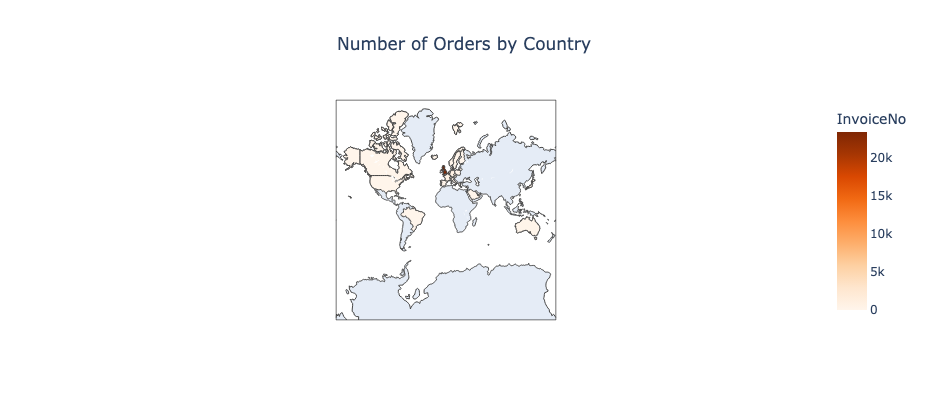

In [141]:
# Aggregate the data by country
orders_by_country = df.groupby('Country')['InvoiceNo'].nunique().reset_index()

# Plot the choropleth map
fig = px.choropleth(orders_by_country, 
                    locations='Country', 
                    locationmode='country names',
                    color='InvoiceNo',
                    hover_name='Country',
                    color_continuous_scale='oranges',
                    title='Number of Orders by Country')
fig.update_layout(geo=dict(showframe=True, 
                           projection=dict(type='mercator')),
                  title_x=0.5,
                 width=800,
                 height=400)
fig.show()

### Inferences on Country & Grouping
- UK and Europe are major sources of orders, indicating significant market presence.
- Grouping countries into regions simplifies analysis and captures broader geographical trends effectively.
- Treating regions as categorical variables facilitates comparison and targeted strategies across different regions.
- Since 90% of the purchases originate from the UK, the clustering results appeared skewed. Therefore, this column was excluded in the final iteration of modeling.

In [142]:
# print(df['Country'].value_counts())

# Define the mapping of countries to regions
country_to_region = {
    'United Kingdom': 'UK',
    'Germany': 'Europe',
    'France': 'Europe',
    'EIRE': 'Europe',
    'Spain': 'Europe',
    'Netherlands': 'Europe',
    'Belgium': 'Europe',
    'Switzerland': 'Europe',
    'Portugal': 'Europe',
    'Italy': 'Europe',
    'Channel Islands': 'Europe',
    'Finland': 'Europe',
    'Cyprus': 'Europe',
    'Sweden': 'Europe',
    'Austria': 'Europe',
    'Denmark': 'Europe',
    'Norway': 'Europe',
    'Poland': 'Europe',
    'Greece': 'Europe',
    'Malta': 'Europe',
    'European Community': 'Europe',
    'Lithuania': 'Europe',
    'Czech Republic': 'Europe',
    'Iceland': 'Europe',
    'USA': 'NorthAmerica',
    'Canada': 'NorthAmerica',
    'Australia': 'AsiaPacific',
    'Japan': 'AsiaPacific',
    'Singapore': 'AsiaPacific'
}

# Group countries into regions
df['Region'] = df['Country'].map(country_to_region).fillna('Other')

# Display the distribution of customers by region
customer_distribution_by_region = df['Region'].value_counts()
print(customer_distribution_by_region)

# Group countries into UK & non-UK
df['isUK'] = df['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)
# df['isUK'].value_counts()


UK              495478
Europe           42880
AsiaPacific       1846
Other             1263
NorthAmerica       442
Name: Region, dtype: int64


Percentage distribution of customers by region:


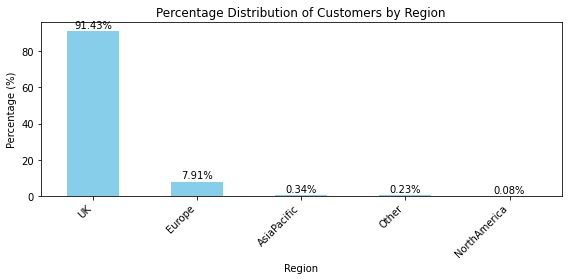

In [143]:
# Calculate distribution of customers by region
customer_distribution_by_region = df['Region'].value_counts()

# Calculate percentage distribution by region
percentage_by_region = (customer_distribution_by_region / len(df)) * 100

# Print percentage distribution by region
print("Percentage distribution of customers by region:")
# print(percentage_by_region)

# Plotting the percentage distribution
plt.figure(figsize=(8, 4))  # Set the figure size (width, height)
percentage_by_region.plot(kind='bar', color='skyblue')  # Create a bar plot
plt.title('Percentage Distribution of Customers by Region')  # Set the plot title
plt.xlabel('Region')  # Set the label for the x-axis
plt.ylabel('Percentage (%)')  # Set the label for the y-axis

# Add labels showing the percentage values on top of each bar
for i, percentage in enumerate(percentage_by_region):
    plt.text(i, percentage + 0.5, f'{percentage:.2f}%', ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap of labels
plt.show()  # Display the plot

## 1.3 Orders By Customer

In [144]:
# Number of unique customers
num_customers = df['CustomerID'].nunique()
print("\nNumber of Unique Customers:", num_customers)

# Total number of orders per customer
orders_per_customer = df.groupby('CustomerID')['InvoiceNo'].nunique()
print("\nTotal Number of Orders per Customer:")
print(orders_per_customer.describe())


Number of Unique Customers: 4372

Total Number of Orders per Customer:
count    4372.000000
mean        5.075480
std         9.338754
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       248.000000
Name: InvoiceNo, dtype: float64


### Inferences on Orders
With 4,372 unique customers, the average number of orders per customer is approximately 5, indicating a substantial level of engagement. However, there is notable variability in customer behavior, with the standard deviation of orders per customer being 9.34, suggesting diverse levels of activity among customers.

## 1.4 Distribution of Orders Per Customer

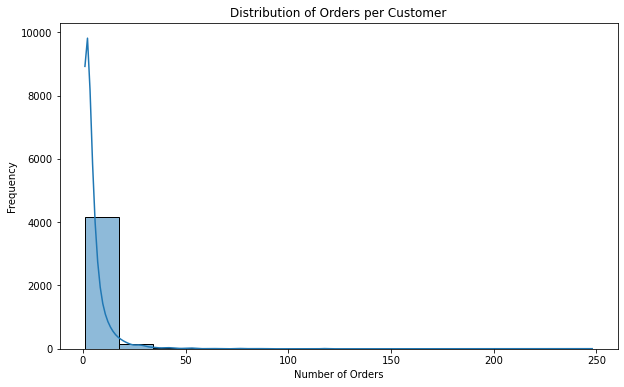

In [145]:
# Visualize distribution of orders per customer
plt.figure(figsize=(10, 6))
sns.histplot(orders_per_customer, bins=15, kde=True)
plt.title('Distribution of Orders per Customer')
plt.xlabel('Number of Orders')
plt.ylabel('Frequency')
plt.show()

### Inferences on Orders Distribution
The distribution of orders per customer, as depicted by the histogram plot, shows that the majority of customers placed a relatively low number of orders. The distribution is positively skewed, with a peak around 1 to 5 orders per customer. A significant proportion of customers made only 1 order, while fewer customers made progressively higher numbers of orders. This suggests that while a large portion of customers may be occasional shoppers, there exists a smaller group of more frequent shoppers who contribute to a higher number of orders.

## 1.5 Top Purchased Products


Number of Unique Products: 4070

Top 10 Most Purchased Products:
WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
ASSORTED COLOUR BIRD ORNAMENT         1501
SET OF 3 CAKE TINS PANTRY DESIGN      1473
PACK OF 72 RETROSPOT CAKE CASES       1385
LUNCH BAG  BLACK SKULL.               1350
NATURAL SLATE HEART CHALKBOARD        1280
Name: Description, dtype: int64


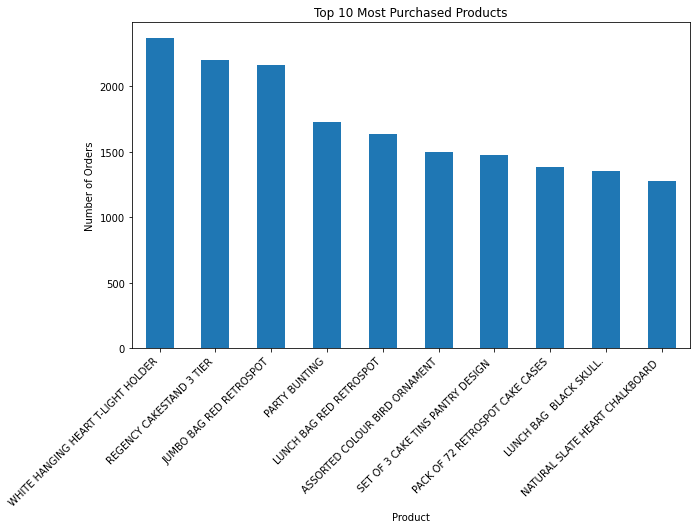

In [146]:
# Product insights
# Number of unique products
num_products = df['StockCode'].nunique()
print("\nNumber of Unique Products:", num_products)

# Top 10 most purchased products
top_products = df['Description'].value_counts().head(10)
print("\nTop 10 Most Purchased Products:")
print(top_products)

# Visualize top 10 most purchased products
plt.figure(figsize=(10, 6))
top_products.plot(kind='bar')
plt.title('Top 10 Most Purchased Products')
plt.xlabel('Product')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45, ha='right')
plt.show()

### Inferences on Top Products
The dataset contains 4,070 unique items. The top 10 most purchased products provide valuable insights into customer preferences, with items like "WHITE HANGING HEART T-LIGHT HOLDER" and "REGENCY CAKESTAND 3 TIER" being among the most popular. These insights can inform inventory management, marketing strategies, and product recommendations to enhance customer satisfaction and drive sales.

## 1.6 Transactions Per Customer

In [147]:
# Group by CustomerID and InvoiceNo, then calculate the count of unique products per invoice
products_per_transaction = df.groupby(['CustomerID', 'InvoiceNo'])['StockCode'].nunique().reset_index()
print(products_per_transaction.head(10))

# Group by CustomerID and calculate the average, minimum, and maximum number of products purchased per transaction
products_per_customer = products_per_transaction.groupby('CustomerID')['StockCode'].agg(['mean', 'min', 'max']).reset_index()

# Rename columns for clarity
products_per_customer.columns = ['CustomerID', 'Avg_Products_Per_Transaction', 'Min_Products_Per_Transaction', 'Max_Products_Per_Transaction']

# Display the insights
print("\n***Insights on Number of Products Purchased per Transaction per Customer:***")
print(products_per_customer.head())

  CustomerID InvoiceNo  StockCode
0      12346    541431          1
1      12346   C541433          1
2      12347    537626         31
3      12347    542237         29
4      12347    549222         24
5      12347    556201         18
6      12347    562032         22
7      12347    573511         47
8      12347    581180         11
9      12348    539318         13

***Insights on Number of Products Purchased per Transaction per Customer:***
  CustomerID  Avg_Products_Per_Transaction  Min_Products_Per_Transaction  \
0      12346                          1.00                             1   
1      12347                         26.00                            11   
2      12348                          6.75                             3   
3      12349                         73.00                            73   
4      12350                         17.00                            17   

   Max_Products_Per_Transaction  
0                             1  
1                      

In [148]:
products_per_transaction.head(5)

CustomerID InvoiceNo  StockCode
0      12346    541431          1
1      12346   C541433          1
2      12347    537626         31
3      12347    542237         29
4      12347    549222         24

In [149]:
products_per_customer.head()

CustomerID  Avg_Products_Per_Transaction  Min_Products_Per_Transaction  \
0      12346                          1.00                             1   
1      12347                         26.00                            11   
2      12348                          6.75                             3   
3      12349                         73.00                            73   
4      12350                         17.00                            17   

   Max_Products_Per_Transaction  
0                             1  
1                            47  
2                            13  
3                            73  
4                            17

### Inferences on transactions
- Customer 12346 made a single purchase, followed by a cancellation, with only one product involved in each transaction.
- Customer 12347 exhibits a varying number of products per transaction, ranging from 11 to 47, with an average of approximately 26 products per transaction.
- Customer 12349 made transactions involving a high number of products consistently, with all transactions consisting of 73 products.

## 1.7 Cancellations
## Sensitivity analysis for cancellation invoices in the dataset

In [150]:
df[df['InvoiceNo'].str.startswith('C')].head()

InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          Discount        -1   
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237   C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

         InvoiceDate  UnitPrice CustomerID         Country Region  isUK  
141   12/1/2010 9:41      27.50      14527  United Kingdom     UK     1  
154   12/1/2010 9:49       4.65      15311  United Kingdom     UK     1  
235  12/1/2010 10:24       1.65      17548  United Kingdom     UK     1  
236  12/1/2010 10:24       0.29      17548  United Kingdom     UK     1  
237  12/1/2010 10:24       0.29      17548  United Kingdom     UK     1

In [151]:
len(df[df['InvoiceNo'].str.startswith('C')])/len(df) * 100

1.7139409015166756

In [152]:
# Filter records with positive quantity and 'InvoiceNo' indicating cancellation
positive_quantity_cancellations = df[(df['Quantity'] > 0) & (df['InvoiceNo'].str.startswith('C'))]

negative_price_cancellations = df[(df['UnitPrice'] < 0) & (df['InvoiceNo'].str.startswith('C'))]

# Check if there are any records
if not positive_quantity_cancellations.empty:
    print("Records with positive quantity but cancellation in invoice:")
    print(positive_quantity_cancellations)
else:
    print("No records with positive quantity but cancellation in invoice found.")

if not positive_quantity_cancellations.empty:
    print("Records with negative price but cancellation in invoice:")
    print(negative_price_cancellations)
else:
    print("No records with negative price but cancellation in invoice found.")

No records with positive quantity but cancellation in invoice found.
No records with negative price but cancellation in invoice found.


In [153]:
# Create a copy of the original dataset for sensitivity analysis
df_copy = df.copy()

# Remove cancellation entries
df_without_cancellations = df_copy[~df_copy['InvoiceNo'].str.startswith('C')]  # Remove cancellation entries

# Calculate total revenue for each approach
total_revenue_with_cancellations = df['Quantity'] * df['UnitPrice'].sum()
total_revenue_without_cancellations = df_without_cancellations['Quantity'] * df_without_cancellations['UnitPrice'].sum()

# Calculate total orders for each approach
total_orders_with_cancellations = df['InvoiceNo'].nunique()
total_orders_without_cancellations = df_without_cancellations['InvoiceNo'].nunique()

# Calculate total quantity for each approach
total_quantity_with_cancellations = df['Quantity'].sum()
total_quantity_without_cancellations = df_without_cancellations['Quantity'].sum()

print("Total Revenue with Cancellations:", total_revenue_with_cancellations.sum())
print("Total Revenue without Cancellations:", total_revenue_without_cancellations.sum())

print("\nTotal Orders with Cancellations:", total_orders_with_cancellations)
print("Total Orders without Cancellations:", total_orders_without_cancellations)

print("\nTotal Quantity with Cancellations:", total_quantity_with_cancellations)
print("Total Quantity without Cancellations:", total_quantity_without_cancellations)


Total Revenue with Cancellations: 12934933831212.3
Total Revenue without Cancellations: 11177060392683.701

Total Orders with Cancellations: 25900
Total Orders without Cancellations: 22064

Total Quantity with Cancellations: 5176450
Total Quantity without Cancellations: 5454024


## <center> 2. Data Preprocessing </center>

## 2.1 Handling Cancellations

### Inferences from the sensitivity analysis above
- The comparison between total revenue with and without cancellations, which stands at approximately 12.93 trillion and 11.18 trillion, respectively, underscores the significant financial impact of cancellations on the business. But this could also be contradictory with having higher revenue with cancellations. 
- By explicitly distinguishing between these transaction types cancellations vs purchase, the dataset becomes more transparent, enabling deeper insights into customer behavior and preferences specific to cancellations and purchases.
- Clustering results are skewed due to cancellations, with only 1.7% of cancellations they are removed from the analysis.

In [154]:
# Creating TransactionType column to retain Cancellations
df['TransactionType'] = 1
df.loc[df['InvoiceNo'].str.startswith('C'), 'TransactionType'] = 0

Removing Cancellations

In [155]:
# Toggle this based on if cancellations retained in clustering analysis or not
df = df[df['TransactionType'] != 0]

## 2.2 Handling Missing Values

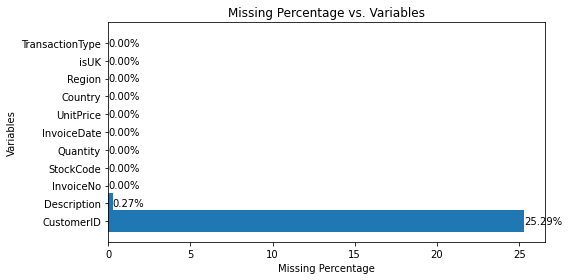

             Column  Missing Percentage
6        CustomerID           25.289465
2       Description            0.272990
0         InvoiceNo            0.000000
1         StockCode            0.000000
3          Quantity            0.000000
4       InvoiceDate            0.000000
5         UnitPrice            0.000000
7           Country            0.000000
8            Region            0.000000
9              isUK            0.000000
10  TransactionType            0.000000


In [156]:
def check_missing_values(df, plot=False):
    # Check for missing values
    missing_values = df.isnull().sum()

    # Calculate percentage of missing values
    missing_percentage = (df.isnull().sum() / len(df)) * 100

    # Create a DataFrame to display the results
    missing_values_df = pd.DataFrame({'Column': df.columns, 'Missing Percentage': missing_percentage})
    missing_values_df.reset_index(drop=True, inplace=True)

    # Sort the DataFrame by missing percentage
    # missing_values_df = missing_values_df[missing_values_df['Missing Percentage'] != 0]
    missing_values_df = missing_values_df.sort_values(by='Missing Percentage', ascending=False)

    # print(missing_values_df)
    # Plot missing percentage vs. variables
    if plot:
        #df_with_missing_only = missing_values_df[missing_values_df['#Missing Values'] > 0]
        plt.figure(figsize=(8, 4))
        plt.barh(missing_values_df['Column'], missing_values_df['Missing Percentage'], height=1.2)
        for index, value in enumerate(missing_values_df['Missing Percentage']):
            plt.text(value, index, f'{value:.2f}%', ha='left', va='center')
        plt.xlabel('Missing Percentage')
        plt.ylabel('Variables')
        plt.title('Missing Percentage vs. Variables')
        plt.tight_layout()  # Adjust subplot parameters to give specified padding
        plt.show()
    return missing_values_df

# Display the DataFrame sorted by missing percentage
print(check_missing_values(df, plot=True))

In [157]:
df[df['CustomerID'].isnull() | df['Description'].isnull()].head()

InvoiceNo StockCode                      Description  Quantity  \
622     536414     22139                              NaN        56   
1443    536544     21773  DECORATIVE ROSE BATHROOM BOTTLE         1   
1444    536544     21774  DECORATIVE CATS BATHROOM BOTTLE         2   
1445    536544     21786               POLKADOT RAIN HAT          4   
1446    536544     21787            RAIN PONCHO RETROSPOT         2   

          InvoiceDate  UnitPrice CustomerID         Country Region  isUK  \
622   12/1/2010 11:52       0.00        NaN  United Kingdom     UK     1   
1443  12/1/2010 14:32       2.51        NaN  United Kingdom     UK     1   
1444  12/1/2010 14:32       2.51        NaN  United Kingdom     UK     1   
1445  12/1/2010 14:32       0.85        NaN  United Kingdom     UK     1   
1446  12/1/2010 14:32       1.66        NaN  United Kingdom     UK     1   

      TransactionType  
622                 1  
1443                1  
1444                1  
1445                1  
1446                1

In [158]:
# Group by StockCode and count unique Description values
stockcode_description_count = df.groupby('StockCode')['Description'].nunique()

# Filter for StockCodes with more than one unique Description
inconsistent_stockcodes = stockcode_description_count[stockcode_description_count > 1]

# Display the inconsistent StockCodes and their unique Description counts
print("Inconsistent StockCodes and their unique Description counts:")
print(inconsistent_stockcodes.head())

Inconsistent StockCodes and their unique Description counts:
StockCode
10080     2
10133     2
15058A    2
15058C    2
16008     2
Name: Description, dtype: int64


### Inference on missing values
__Customer IDs__ <br>
Removing rows with missing customer IDs makes sense because it ensures data integrity, reduces bias, and facilitates customer-centric analysis by focusing on complete and reliable customer data. This approach helps maintain the quality of the dataset for accurate insights into customer behavior and segmentation.

__Description__ <br>
We cannot impute missing descriptions from stock codes due to one stock code being mapped to more than one description. Also the missing descriptions have been linked to missing Customer Ids. Hence removing the rows with missing CustomerIds would solve description inconsistency as well.

In [159]:
# Remove rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Check the new shape of the DataFrame
print("Shape of DataFrame after removing rows with missing CustomerID:", df.shape)
print(check_missing_values(df))

Shape of DataFrame after removing rows with missing CustomerID: (397924, 11)
             Column  Missing Percentage
0         InvoiceNo                 0.0
1         StockCode                 0.0
2       Description                 0.0
3          Quantity                 0.0
4       InvoiceDate                 0.0
5         UnitPrice                 0.0
6        CustomerID                 0.0
7           Country                 0.0
8            Region                 0.0
9              isUK                 0.0
10  TransactionType                 0.0


## 2.2 Identify and Handling Duplicate Records

Dropping duplicates in the customer dataset is crucial for ensuring data integrity and analysis accuracy. 
- Firstly, removing duplicate rows helps in preventing skewed insights by eliminating redundant information, ensuring that each transaction record is represented only once in the analysis. 
- Secondly, it aids in maintaining the dataset's cleanliness, as duplicate entries may distort statistical measures. 
- Lastly, it improves computational efficiency by reducing the size of the dataset, enabling faster processing and analysis of customer behavior and preferences.

In [160]:
# Identify duplicate rows
print("Number of duplicate rows:", df.duplicated().sum())
print("Number of duplicate rows %:", df.duplicated().sum()/len(df) * 100)

# Drop duplicate rows by keeping the first occurence
df = df.drop_duplicates()
print(df.shape)

Number of duplicate rows: 5192
Number of duplicate rows %: 1.3047717654627518
(392732, 11)


## 2.3 Handling Unit Prices Anamoly

In [161]:
# Filter out records with unit price equal to 0
zero_unit_price_records = df[df['UnitPrice'] == 0]

# Calculate descriptive statistics for Quantity with 0 unit prices
stats_zero_unit_price = zero_unit_price_records['Quantity'].describe()

# Print statistics and explanation
print("Statistics for Quantity with 0 unit prices:")
print(stats_zero_unit_price)
print("\nPercentage of rows with Unit Price 0: {:.3f}%".format(len(stats_zero_unit_price)/len(df)*100))

Statistics for Quantity with 0 unit prices:
count       40.000000
mean       347.100000
std       1978.311813
min          1.000000
25%          1.000000
50%          4.500000
75%         24.000000
max      12540.000000
Name: Quantity, dtype: float64

Percentage of rows with Unit Price 0: 0.002%


### Inferences on Unit Prices
- There are 40 instances of transactions with 0 unit prices, indicating occasional occurrences. This suggests they may represent specific types of transactions or anomalies rather than a pervasive issue throughout the dataset.
- Despite zero unit prices, transactions exhibit significant variability in the quantity of items involved, ranging from single-item transactions to bulk orders exceeding 12,500 items.
- On average, these transactions involve approximately 347 items, with 25% involving only 1 item(or fewer) and 75% involving 24 items(or fewer). The median quantity is 4, reflecting a diverse composition of transactions.

Removing rows with zero unit prices is important because:
1. It ensures accurate calculations of total revenue and average unit price.
2. It avoids distorting statistical analyses and modeling due to outliers or incorrect data.

In [162]:
df = df[df['UnitPrice'] != 0]

## 2.4 Detecting and Addressing Stock Code Irregularities

In [163]:
df['StockCode'].unique()

array(['85123A', '71053', '84406B', ..., '90214Z', '90089', '23843'],
      dtype=object)

### Inferences on StockCodes #1
Above, it's evident that the typical length of stock codes ranges from 5 to 6 characters. Now, let's verify whether there are any stock codes with fewer/higher characters.

In [164]:
# Detect stock codes with less than 5 or 6 characters
df[df['StockCode'].str.len() < 5].head(6)

InvoiceNo StockCode Description  Quantity      InvoiceDate  UnitPrice  \
45      536370      POST     POSTAGE         3   12/1/2010 8:45      18.00   
386     536403      POST     POSTAGE         1  12/1/2010 11:27      15.00   
1123    536527      POST     POSTAGE         1  12/1/2010 13:04      18.00   
1423    536540        C2    CARRIAGE         1  12/1/2010 14:05      50.00   
2239    536569         M      Manual         1  12/1/2010 15:35       1.25   
2250    536569         M      Manual         1  12/1/2010 15:35      18.95   

     CustomerID         Country  Region  isUK  TransactionType  
45        12583          France  Europe     0                1  
386       12791     Netherlands  Europe     0                1  
1123      12662         Germany  Europe     0                1  
1423      14911            EIRE  Europe     0                1  
2239      16274  United Kingdom      UK     1                1  
2250      16274  United Kingdom      UK     1                1

In [165]:
irregular_stock_codes_gt7 = df[df['StockCode'].str.len() > 7]
print(irregular_stock_codes_gt7['StockCode'].unique())

['BANK CHARGES']


In [166]:
irregular_stock_codes_lt5 = df[df['StockCode'].str.len() < 5]
print(irregular_stock_codes_lt5['StockCode'].unique())

['POST' 'C2' 'M' 'PADS' 'DOT']


In [167]:
df[df['StockCode'] == 'PADS'].head(1)

InvoiceNo StockCode                 Description  Quantity  \
157195    550193      PADS  PADS TO MATCH ALL CUSHIONS         1   

           InvoiceDate  UnitPrice CustomerID         Country Region  isUK  \
157195  4/15/2011 9:27      0.001      13952  United Kingdom     UK     1   

        TransactionType  
157195                1

In [168]:
df[df['StockCode'] == 'DOT'].head(1)

InvoiceNo StockCode     Description  Quantity      InvoiceDate  \
317507    564764       DOT  DOTCOM POSTAGE         1  8/30/2011 10:49   

        UnitPrice CustomerID         Country Region  isUK  TransactionType  
317507      11.17      14096  United Kingdom     UK     1                1

In [169]:
df[df['StockCode'] == 'CRUK'].head(1)

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, Region, isUK, TransactionType]
Index: []

In [170]:
print("Percentage of Stock Code Anomalies: {:.2f}%".format((len(irregular_stock_codes_lt5+irregular_stock_codes_gt7)/len(df)) * 100))

Percentage of Stock Code Anomalies: 0.39%


### Inferences on StockCodes #2
- Removing 'M', 'D' and 'BANK CHARGES' codes from the dataset could be necessary to ensure consistency, as these codes likely represent non-product items such as manual fees, discounts or bank chrages.
- "POST" and "C2" are for postage and carriage appearing across various countries. We may consider removing these entries, since they do not pertain to customer behavior.
- 'PADS' likely represents a placeholder or generic item with an unusually low unit price, suggesting it may not correspond to a specific product.
- 'DOT' appears to be associated with postage costs ('DOTCOM POSTAGE'), indicating it's likely an auxiliary item rather than a product sold by the platform, and its inclusion could introduce noise into the dataset.
- 'CRUK' represents a commission associated with a cancellation rather than a product sold, making it irrelevant for sales analysis and should be excluded to maintain the dataset's integrity.

In [171]:
# Remove irregular stock codes from the dataset as these account for only 0.39%
df = df[~df['StockCode'].isin(irregular_stock_codes_gt7['StockCode'])]
df = df[~df['StockCode'].isin(irregular_stock_codes_lt5['StockCode'])]

# Print the first few rows of the cleaned dataset
print("Cleaned Dataset:")
print(df.shape)

Cleaned Dataset:
(391150, 11)


## 2.5 Total Purchase Price
 Calculating toal purchase price per order per customer helps in identifying high-value customers, or understanding overall spending patterns.

In [172]:
# Calculate the total purchase price per transaction
df['PurchasePrice'] = df['Quantity'] * df['UnitPrice']

# Group by CustomerID and InvoiceNo, then calculate the sum of PurchasePrice per transaction order
total_purchase_per_transaction = df.groupby(['CustomerID', 'InvoiceNo'])['PurchasePrice'].sum().reset_index()
# print(total_purchase_per_transaction)

# Merge the total purchase per transaction back to the original dataframe
df = pd.merge(df, total_purchase_per_transaction, on=['CustomerID', 'InvoiceNo'], how='left')
df.rename(columns={'PurchasePrice_x': 'PurchasePrice'}, inplace=True)
df.rename(columns={'PurchasePrice_y': 'TotalInvoicePrice'}, inplace=True)

# Display a single invoice
df[(df['CustomerID'] == '17850') & (df['InvoiceNo'] == '536365')]

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   

      InvoiceDate  UnitPrice CustomerID         Country Region  isUK  \
0  12/1/2010 8:26       2.55      17850  United Kingdom     UK     1   
1  12/1/2010 8:26       3.39      17850  United Kingdom     UK     1   
2  12/1/2010 8:26       2.75      17850  United Kingdom     UK     1   
3  12/1/2010 8:26       3.39      17850  United Kingdom     UK     1   
4  12/1/2010 8:26       3.39      17850  United Kingdom     UK     1   
5  12/1/2010 8:26       7.65      17850  United Kingdom     UK     1   
6  12/1/2010 8:26       4.25      17850  United Kingdom     UK     1   

   TransactionType  PurchasePrice  TotalInvoicePrice  
0                1          15.30             139.12  
1                1          20.34             139.12  
2                1          22.00             139.12  
3                1          20.34             139.12  
4                1          20.34             139.12  
5                1          15.30             139.12  
6                1          25.50             139.12

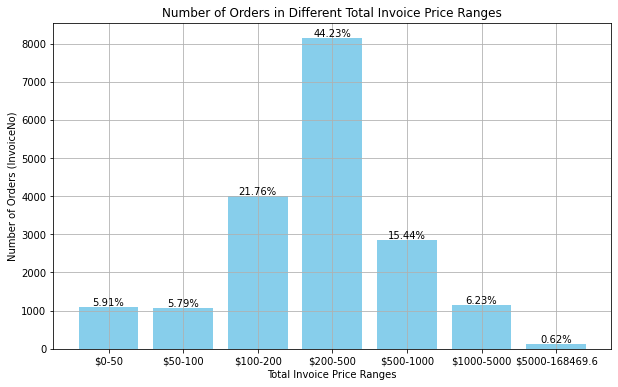

In [173]:
# Group by TotalInvoicePrice ranges and count the number of unique InvoiceNo
invoice_price_ranges = [(0, 50), (50, 100), (100, 200), (200, 500), (500, 1000), (1000, 5000), (5000, df['TotalInvoicePrice'].max())]
invoice_counts = []

for start, end in invoice_price_ranges:
    subset = df[(df['TotalInvoicePrice'] >= start) & (df['TotalInvoicePrice'] < end)]
    invoice_counts.append(subset['InvoiceNo'].nunique())

percentage_freq = [(count / df['InvoiceNo'].nunique()) * 100 for count in invoice_counts]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(invoice_price_ranges)), invoice_counts, color='skyblue')
plt.xlabel('Total Invoice Price Ranges')
plt.ylabel('Number of Orders (InvoiceNo)')
plt.title('Number of Orders in Different Total Invoice Price Ranges')
plt.xticks(range(len(invoice_price_ranges)), [f'${start}-{end}' for start, end in invoice_price_ranges])
plt.grid(True)

# Add percentage frequency as annotations
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage_freq[i]:.2f}%', ha='center', va='bottom')
    
plt.show()

### Inferences on Total Purchase Prices

- It is evident that a highest portion of orders, 44.23% lies within the price range of 200-500, suggesting that this range encompasses a considerable proportion of the dataset's transactions.
- The majority of orders fall within the lower price ranges with approximately 5.9% of orders having a total invoice price between 0-50, around 5.79% falling between 50-100, and around 21.76% falling between 100-200.
- As the price ranges increase, the percentage of orders decreases, indicating a decline in the frequency of higher-priced transactions beyond 500.

## 2.6 Product Descriptions

To prepare product descriptions for input to classification models, we'll first ensure consistency by applying uppercase formatting. Next, we'll remove punctuation and stopwords, as they lack meaningful information.

In [174]:
df['Description'].nunique()

3871

In [175]:
df['Description'].unique()[:15]

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER',
       'KNITTED UNION FLAG HOT WATER BOTTLE',
       'RED WOOLLY HOTTIE WHITE HEART.', 'SET 7 BABUSHKA NESTING BOXES',
       'GLASS STAR FROSTED T-LIGHT HOLDER', 'HAND WARMER UNION JACK',
       'HAND WARMER RED POLKA DOT', 'ASSORTED COLOUR BIRD ORNAMENT',
       "POPPY'S PLAYHOUSE BEDROOM ", "POPPY'S PLAYHOUSE KITCHEN",
       'FELTCRAFT PRINCESS CHARLOTTE DOLL', 'IVORY KNITTED MUG COSY ',
       'BOX OF 6 ASSORTED COLOUR TEASPOONS'], dtype=object)

It is observed that the descriptions are in Uppercase. Now, let's check if there are any descriptions in lowercase.

In [176]:
lowercase_desc = df[df['Description'].str.contains('[a-z]')]
print(lowercase_desc['Description'].unique())

['BAG 500g SWIRLY MARBLES' 'POLYESTER FILLER PAD 45x45cm'
 'POLYESTER FILLER PAD 45x30cm' 'POLYESTER FILLER PAD 40x40cm'
 'FRENCH BLUE METAL DOOR SIGN No' 'BAG 250g SWIRLY MARBLES'
 'BAG 125g SWIRLY MARBLES' '3 TRADITIONAl BISCUIT CUTTERS  SET'
 'FOLK ART GREETING CARD,pack/12' 'ESSENTIAL BALM 3.5g TIN IN ENVELOPE'
 'POLYESTER FILLER PAD 65CMx65CM' 'NUMBER TILE VINTAGE FONT No '
 'NUMBER TILE COTTAGE GARDEN No' 'POLYESTER FILLER PAD 30CMx30CM'
 'POLYESTER FILLER PAD 60x40cm' 'FLOWERS HANDBAG blue and orange'
 'Next Day Carriage' 'THE KING GIFT BAG 25x24x12cm'
 'High Resolution Image']


### Inferences on Product Descriptions #1
- Some descriptions contain lowercase characters. To maintain consistency, let's convert them to uppercase.
- 'Next Day Carriage' and 'High Resolution Image' do not provide relevant product information and can be removed.

In [177]:
# Convert descriptions to uppercase
df['Description'] = df['Description'].str.upper()

# Print the percentages
print("Percentage of Irrelevant Descriptions: {:.2f}%"
      .format(((df[df['Description'].str.contains('NEXT DAY CARRIAGE')].shape[0] + 
                df[df['Description'].str.contains('HIGH RESOLUTION IMAGE')].shape[0]) / len(df)) * 100))

# Remove entries containing 'Next Day Carriage' and 'High Resolution Image'
df = df[~df['Description'].str.contains('NEXT DAY CARRIAGE')]
df = df[~df['Description'].str.contains('HIGH RESOLUTION IMAGE')]

Percentage of Irrelevant Descriptions: 0.02%


### Removing Punctuation: 
Removing punctuation marks from the descriptions, as they often do not add meaningful information for classification tasks.

In [178]:
# Function to remove punctuation from text
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))
    
# Remove punctuation from the 'Description' column
df['Description'] = df['Description'].apply(remove_punctuation)

print(df['Description'].nunique())

3859


### Removing Stopwords: 
Removing common words that occur frequently in the language but do not carry significant meaning for classification. Examples: "the", "is", "are", etc.

In [179]:
# Function to remove stopwords from text
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    clean_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(clean_words)

# Remove stopwords from the 'Description' column
df['Description'] = df['Description'].apply(remove_stopwords)
print(df['Description'].nunique())

3828


### Stemming vs Lemmatization:
- Stemming involves reducing words to their base or root form by removing affixes, and is generally simpler and faster.
- Lemmatization involves the morphological analysis of words and reducing them to their dictionary form or lemma.

In the context of product descriptions, where words are often already in their base form and there is minimal ambiguity in the words used, stemming and Lemmatization did not result in any transformation.

In [180]:
# # Initialize Porter Stemmer
# stemmer = PorterStemmer()

# # Function to perform stemming on text
# def stem_text(text):
#     # Tokenize the text
#     tokens = nltk.word_tokenize(text)
#     # Apply stemming to each token
#     stemmed_tokens = [stemmer.stem(token) for token in tokens]
#     # Join stemmed tokens back into text
#     stemmed_text = ' '.join(stemmed_tokens)
#     return stemmed_text

# # Apply stemming to the 'Description' column
# df['Stemmed_Description'] = df['Description'].apply(stem_text)

# # Display the updated DataFrame
# print(df[['Description', 'Stemmed_Description']].head())


### WordCloud on Product Categories

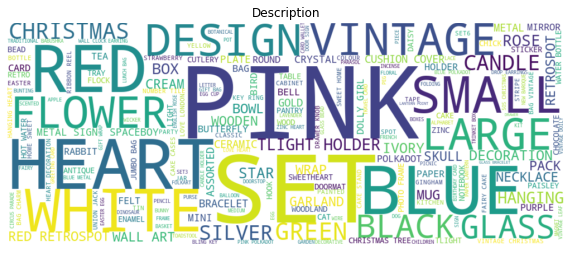

In [181]:
# Create a copy of the DataFrame
df_copy = df.copy()

# Drop rows with missing 'Description' values in the copy
df_copy.dropna(subset=['Description'], inplace=True)

# Join 'Description' values into a single string
text = ' '.join(df_copy['Description'].unique())

# Create a WordCloud object
wordcloud = WordCloud(width=1000, height=400, background_color='white').generate(text)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
# plt.title('Word Cloud from Description Column')
plt.title('Description')
plt.axis('off')
plt.show()


### Categorizing Product Descriptions - LDA
- The objective is to understand customer product behavior by assigning categories to product descriptions. This facilitates the analysis of large datasets, providing structured insights into customer preferences and purchasing patterns.
- Let's employ Latent Dirichlet Allocation (LDA), a topic modeling technique, to identify 20 latent topics within the product descriptions. By preprocessing the descriptions and converting them into a bag-of-words representation, the underlying themes present in the data are extracted.
- After identifying the topics, meaningful categories are assigned based on the top words associated with each topic. These categories provide a structured framework for interpreting and analyzing customer product behavior, enabling us to gain insights into their preferences and purchasing habits.

In [182]:
# Convert category descriptions to a bag-of-words representation
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['Description'])

# Apply Latent Dirichlet Allocation (LDA) for topic modeling
lda = LatentDirichletAllocation(n_components=20, random_state=42)
lda.fit(X)

# Extract top words for each topic
feature_names = vectorizer.get_feature_names()
n_top_words = 10
topic_top_words = {}
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
    topic_top_words[f'Topic {topic_idx + 1}'] = [feature_names[i] for i in top_words_idx]

# Display top words for each topic
for topic, top_words in topic_top_words.items():
    print(f'{topic}: {" ".join(top_words)}')


Topic 1: design pantry set mug vintage reel ribbon 20 napkins coffee
Topic 2: bag jumbo vintage paisley black lunch leaf doily pink red
Topic 3: christmas rose assorted 50s colour bird paper kit wrap chain
Topic 4: set mini baking doilies cases cutters tlights cookie jam 36
Topic 5: wooden garden set antique magic hook traditional white childs rack
Topic 6: lunch spaceboy design box bag love natural london mini slate
Topic 7: cream flower enamel ceramic lights white lantern strawberry food set
Topic 8: set tins jar cutlery gift jam christmas retrospot candle piece
Topic 9: bunting wall paper heart party art red spotty zinc clock
Topic 10: home pencils sweet tube 12 red small retrospot notebook babushka
Topic 11: heart hanging holder tlight decoration small glass wicker large christmas
Topic 12: blue clock drawer knob alarm bakelike set red round french
Topic 13: polkadot bottle hot water pink blue candles ribbons heart red
Topic 14: pink childrens apron trinket garland felt rabbit ligh

In [183]:
# Define categories for each topic based on top words
topic_categories = {
    'Topic 1': 'Design&Kitchen',
    'Topic 2': 'Bags&Accessories',
    'Topic 3': 'Christmas&Gifts',
    'Topic 4': 'BakingEssentials',
    'Topic 5': 'Wooden&GardenDecor',
    'Topic 6': 'LunchEssentials',
    'Topic 7': 'HomeDecor',
    'Topic 8': 'KitchenStorage',
    'Topic 9': 'Party&WallDecor:',
    'Topic 10': 'Stationery&Home',
    'Topic 11': 'DecorativeAccessories',
    'Topic 12': 'Wall&StorageSupplies',
    'Topic 13': 'SeasonalGifts',
    'Topic 14': 'KidsCrafts',
    'Topic 15': 'Baking&PartySupplies',
    'Topic 16': 'Retro&VintageStyle',
    'Topic 17': 'Seasonal&VintageDecor',
    'Topic 18': 'GiftBoxes&Decor',
    'Topic 19': 'ClassicTea&Tableware',
    'Topic 20': 'PhotoFrames&Gifts'
}

# Assign categories to product descriptions
df['ProductCategory'] = ''
for idx, row in df.iterrows():
    for topic, top_words in topic_top_words.items():
        if any(word in row['Description'].lower() for word in top_words):
            df.at[idx, 'ProductCategory'] = topic_categories[topic]
            break
        else:
            df.at[idx, 'ProductCategory'] = 'Other'

# Display the updated DataFrame with categories
print(df[['Description', 'ProductCategory']].head())

                           Description     ProductCategory
0    WHITE HANGING HEART TLIGHT HOLDER  Wooden&GardenDecor
1                  WHITE METAL LANTERN  Wooden&GardenDecor
2       CREAM CUPID HEARTS COAT HANGER           HomeDecor
3  KNITTED UNION FLAG HOT WATER BOTTLE       SeasonalGifts
4        RED WOOLLY HOTTIE WHITE HEART    Bags&Accessories


In [184]:
# df['ProductCategory'].value_counts()
df['ProductCategory'].unique()

array(['Wooden&GardenDecor', 'HomeDecor', 'SeasonalGifts',
       'Bags&Accessories', 'Design&Kitchen', 'DecorativeAccessories',
       'Seasonal&VintageDecor', 'Christmas&Gifts', 'Other', 'KidsCrafts',
       'Stationery&Home', 'LunchEssentials', 'Party&WallDecor:',
       'KitchenStorage', 'BakingEssentials', 'ClassicTea&Tableware',
       'Wall&StorageSupplies', 'PhotoFrames&Gifts',
       'Baking&PartySupplies', 'GiftBoxes&Decor', 'Retro&VintageStyle'],
      dtype=object)

### WordCloud on Product Categories

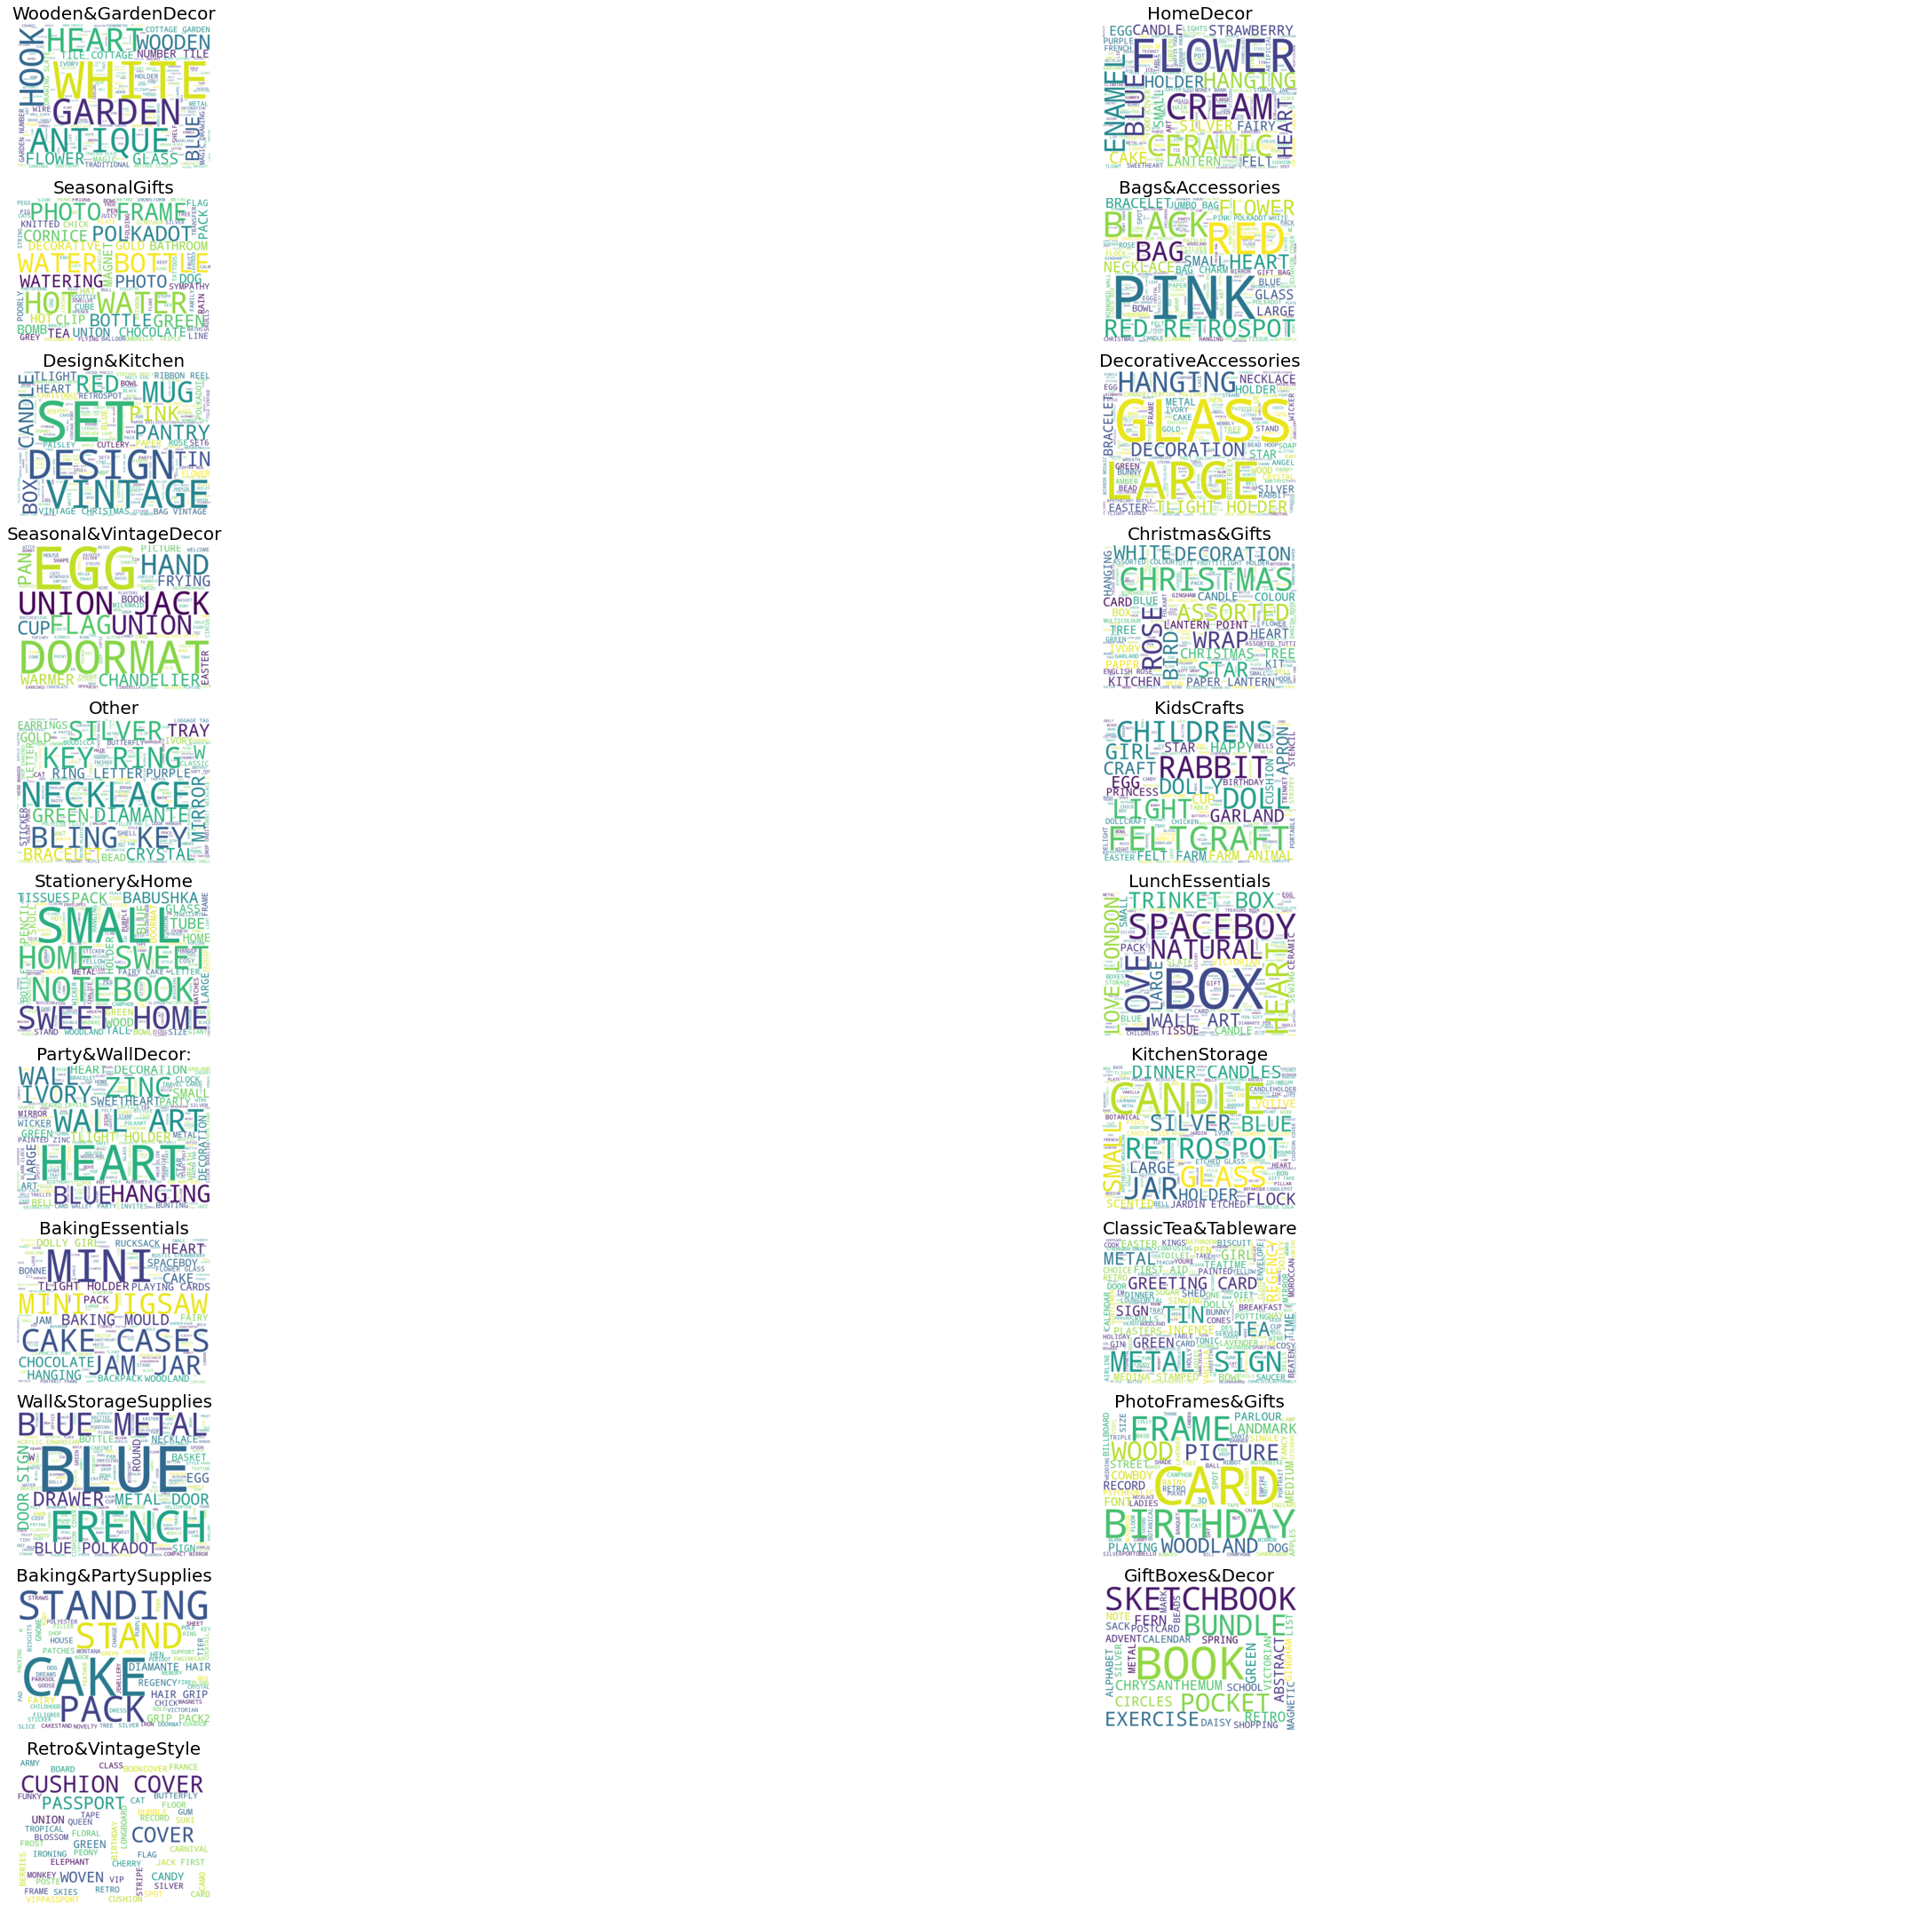

In [185]:
# Determine number of unique product categories
categories = df['ProductCategory'].unique()
num_categories = len(categories)

# Define grid layout for subplots
cols = 2  # Number of columns for subplots
rows = (num_categories + cols - 1) // cols  # Calculate number of rows needed

# Create a figure and subplots
fig, axes = plt.subplots(rows, cols, figsize=(40, 30))

# Iterate over each product category and create a word cloud
for i, category in enumerate(categories):
    # Calculate subplot indices
    row_idx = i // cols
    col_idx = i % cols
    
    # Filter descriptions for the current category
    descriptions = " ".join(df[df['ProductCategory'] == category]['Description'].unique())
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=600, background_color='white').generate(descriptions)
    
    # Plot the word cloud on the appropriate subplot
    ax = axes[row_idx, col_idx] if rows > 1 else axes[col_idx]  # Handle single row case
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(category, fontsize=20)
    ax.axis('off')  # Turn off axis

# Remove unused subplots (if any)
for i in range(num_categories, rows * cols):
    if rows > 1:
        axes.flatten()[i].axis('off')  # Turn off axis for unused subplot
    else:
        axes[i].axis('off')  # Turn off axis for unused subplot

# Adjust layout and display the figure
plt.tight_layout()
plt.show()


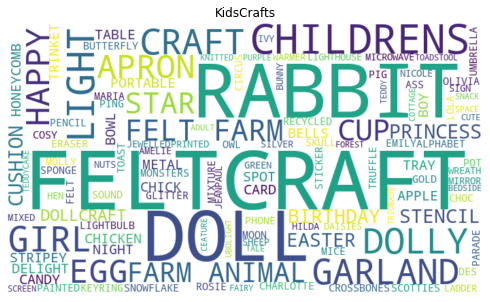

In [186]:
# Filter descriptions for the current category
descriptions = " ".join(df[df['ProductCategory'] == 'KidsCrafts']['Description'].unique())
    
# Generate word cloud
wordcloud = WordCloud(width=700, height=400, background_color='white').generate(descriptions)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
# plt.title('Word Cloud from Description Column')
plt.title('KidsCrafts')
plt.axis('off')
plt.show()

## 2.7 Extracting Customer Purchase Insights

In [187]:
# df = df.drop(columns= ['Recency', 'Frequency', 'MonetaryValue', 'Lifetime', 
#                            'PurchaseDay', 'PurchaseHour', 'PurchaseQuarter', 'AvgPurchaseDurationDays', 
#                            'AvgTotalPurchaseQuantity', 'AvgUnitPrice', 'RepeatPurchaseRate', 
#                            'AvgBasketSize', 'FrequentBuyer'])
#                 # , 'CancellationRecency',       'CancellationFrequency'])

# Convert 'InvoiceDate' column to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Filter DataFrame for 'TransactionType = Purchase' only
df_purchase = df[df['TransactionType'] == 1].copy()

df_purchase['Recency'] = (pd.Timestamp.now() - df_purchase.groupby('CustomerID')['InvoiceDate'].transform('max')).dt.days

df_purchase['Frequency'] = df_purchase.groupby('CustomerID')['InvoiceNo'].transform('nunique')

df_purchase['MonetaryValue'] = df_purchase.groupby('CustomerID')['PurchasePrice'].transform('sum')

df_purchase['Lifetime'] = (df_purchase.groupby('CustomerID')['InvoiceDate'].transform('max') -
                           df_purchase.groupby('CustomerID')['InvoiceDate'].transform('min')).dt.days

df_purchase['PDay'] = df_purchase['InvoiceDate'].dt.dayofweek
df_purchase['PurchaseDay'] = df_purchase.groupby('CustomerID')['PDay'].transform(lambda x: x.mode().iloc[0])

df_purchase['PHour'] = df_purchase['InvoiceDate'].dt.hour
df_purchase['PurchaseHour'] = df_purchase.groupby('CustomerID')['PHour'].transform(lambda x: x.mode().iloc[0])

df_purchase['PQuarter'] = df_purchase['InvoiceDate'].dt.quarter
df_purchase['PurchaseQuarter'] = df_purchase.groupby('CustomerID')['PQuarter'].transform(lambda x: x.mode().iloc[0])

df_purchase['PurchaseDurationDays'] = df_purchase.sort_values(['CustomerID', 'InvoiceDate']).groupby('CustomerID')['InvoiceDate'].diff().dt.days
df_purchase['AvgPurchaseDurationDays'] = df_purchase.groupby('CustomerID')['PurchaseDurationDays'].transform('mean')

df_purchase['PurchaseQuantityPerTransaction'] = df_purchase.groupby('InvoiceNo')['Quantity'].transform('sum')
df_purchase['AvgTotalPurchaseQuantity'] = df_purchase.groupby('CustomerID')['PurchaseQuantityPerTransaction'].transform('mean')

df_purchase['AvgUnitPrice'] = df_purchase.groupby('CustomerID')['UnitPrice'].transform('mean')

df_purchase['RepeatPurchaseRate'] = df_purchase.groupby('CustomerID')['InvoiceNo'].transform(lambda x: x.nunique() > 1).astype(int)

df_purchase['BasketSize'] = df_purchase.groupby('InvoiceNo')['StockCode'].transform('count')
df_purchase['AvgBasketSize'] = df_purchase.groupby('CustomerID')['BasketSize'].transform('mean')

df_purchase['FrequentBuyer'] = (df_purchase['Frequency'] > df_purchase['Frequency'].quantile(0.75)).astype(int)

# Calculate quartiles to define thresholds for High, Medium, and Low values
quantiles = df_purchase['MonetaryValue'].quantile([0.33, 0.66])

# Define ranges for High, Medium, and Low values
low_range = quantiles[0.33]
medium_range = quantiles[0.66]

# Create bins based on predefined ranges
bins = [-float('inf'), low_range, medium_range, float('inf')]
labels = ['Low', 'Medium', 'High']

# Create a new column to categorize customers into High, Medium, and Low value groups
df_purchase['CustomerValue'] = pd.cut(df_purchase['MonetaryValue'], bins=bins, labels=labels)

# Append the calculated columns back to the original DataFrame
df = df.merge(df_purchase[['CustomerID', 'Recency', 'Frequency', 'MonetaryValue', 'Lifetime', 
                           'PurchaseDay', 'PurchaseHour', 'PurchaseQuarter', 'AvgPurchaseDurationDays', 
                           'AvgTotalPurchaseQuantity', 'AvgUnitPrice', 'RepeatPurchaseRate', 
                           'AvgBasketSize', 'FrequentBuyer', 'CustomerValue']].drop_duplicates(subset=['CustomerID']), 
              on='CustomerID', how='left')

# # Replace above NaN values with zeros for cancellation transactions
df.update(df.select_dtypes(include=float).fillna(0))

In [188]:
df[['CustomerID', 'PurchaseDay', 'PurchaseHour', 'PurchaseQuarter', 'AvgPurchaseDurationDays']].head(5)

CustomerID  PurchaseDay  PurchaseHour  PurchaseQuarter  \
0      17850            3             9                4   
1      17850            3             9                4   
2      17850            3             9                4   
3      17850            3             9                4   
4      17850            3             9                4   

   AvgPurchaseDurationDays  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0

## 2.8 Extracting Customer Cancellation Insights

In [189]:
# # Filter DataFrame for 'TransactionType = Cancellation' only
# df_cancellations = df[df['TransactionType'] == 0].copy()

# # 1. Cancellation Rate
# total_orders = df['CustomerID'].nunique()  # Total unique customers
# cancelled_orders = df_cancellations['CustomerID'].nunique()  # Customers with canceled orders
# cancellation_rate = (cancelled_orders / total_orders) * 100
# print("Cancellation Rate: {:.2f}%".format(cancellation_rate))

# # 1. Cancellation Recency
# df_cancellations['CancellationRecency'] = (pd.Timestamp.now() - df_cancellations.groupby('CustomerID')['InvoiceDate'].transform('max')).dt.days

# # 2. Cancellation Frequency
# df_cancellations['CancellationFrequency'] = df_cancellations.groupby('CustomerID')['InvoiceNo'].transform('nunique')

# # Append the calculated columns back to the original DataFrame
# df = df.merge(df_cancellations[['CustomerID', 'CancellationRecency', 'CancellationFrequency']].drop_duplicates(subset=['CustomerID']), 
#               on='CustomerID', how='left')

# # Replace above NaN values with zeros for cancellation transactions
# df.update(df.select_dtypes(include=float).fillna(0))

## 2.8 Converting Strings to Numeric Encodings

Let's enhance our dataset by converting string values into categorical or numeric formats where applicable. Converting features to numeric form allows for mathematical operations, leading to better model performance and generalization.

In [266]:
df_with_encodings = df.copy()

### Country Region

In [267]:
# df_encoded = pd.get_dummies(df_with_encodings['Region'], prefix='Region')
# df_with_encodings = df_with_encodings.join(df_encoded)

# # Drop 'Country' & 'Region'columns
df_with_encodings.drop(columns=['Country'], inplace=True)
df_with_encodings.drop(columns=['Region'], inplace=True)

df_with_encodings.drop(columns=['isUK'], inplace=True)

### Product Category
Pivoting the DataFrame after creating dummy variables to achieve a single row representation with product category columns as 1 or 0 accordingly for each customer.

In [268]:
print(df_with_encodings['CustomerID'].nunique())
# Convert product categories into separate columns using one-hot encoding
one_hot_encoded = pd.get_dummies(df_with_encodings['ProductCategory'], prefix='ProductCategory')
# print(one_hot_encoded)

# Concatenate one-hot encoded columns with the original DataFrame
df_encoded = pd.concat([df_with_encodings['CustomerID'], one_hot_encoded], axis=1)
# print(df_encoded)

# Pivot the DataFrame to have a single row for each customer
df_pivoted = df_encoded.pivot_table(index='CustomerID', aggfunc='max')
# print(df_pivoted)

# Reset the index to make CustomerID a column again
df_pivoted.reset_index(inplace=True)
# print(df_pivoted)

# Fill NaN values with 0
df_pivoted.fillna(0, inplace=True)
# print(df_pivoted)

# Merge the one-hot encoded DataFrame with the original DataFrame on 'CustomerID'
df_with_encodings = pd.merge(df_with_encodings, df_pivoted, on='CustomerID')

4334


In [269]:
df_with_encodings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391068 entries, 0 to 391067
Data columns (total 46 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   InvoiceNo                              391068 non-null  object        
 1   StockCode                              391068 non-null  object        
 2   Description                            391068 non-null  object        
 3   Quantity                               391068 non-null  int64         
 4   InvoiceDate                            391068 non-null  datetime64[ns]
 5   UnitPrice                              391068 non-null  float64       
 6   CustomerID                             391068 non-null  object        
 7   TransactionType                        391068 non-null  int64         
 8   PurchasePrice                          391068 non-null  float64       
 9   TotalInvoicePrice                      391068 no

### CustomerValue

In [270]:
df_encoded = pd.get_dummies(df_with_encodings['CustomerValue'], prefix='CustomerValue')
df_with_encodings = df_with_encodings.join(df_encoded)

# Drop 'CustomerValue' column
df_with_encodings.drop(columns=['CustomerValue'], inplace=True)

## 2.9 Dropping columns 

### Product Description
Convert to Vectors may not be needed:

Dimensionality Reduction: Eliminating the description column reduces data complexity, enhancing clustering efficiency by focusing on essential topic distributions.

Interpretability: Topic-based clustering facilitates clearer insights, aligning with business goals by emphasizing meaningful themes over individual words.

Simplified Implementation: Using topics streamlines model deployment, removing text preprocessing complexities while retaining relevance to business objectives.

In [520]:
# df_with_encodings.drop(columns=['Cluster_y'], inplace=True)
# df_with_encodings = df_with_encodings.drop(columns=['ProductCategory_Storage&Organization_y', 'ProductCategory_VintageItems_y'])

df_cleaned = df_with_encodings.copy()

df_cleaned = df_cleaned.drop(columns=['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'Quantity', 'UnitPrice',
                     'Recency', 'PurchasePrice', 'TotalInvoicePrice', 'ProductCategory', 'TransactionType'])
                # , 'Region']) 'Country']) 'isUK'])




In [521]:
# Drop duplicate rows
df_cleaned.drop_duplicates(inplace=True)

# Display the updated DataFrame
# print(df_cleaned.head())

In [522]:
# df_cleaned.head(10)
df_cleaned[['PurchaseDay', 'PurchaseHour', 'PurchaseQuarter', 'AvgPurchaseDurationDays']].head(5)

PurchaseDay  PurchaseHour  PurchaseQuarter  AvgPurchaseDurationDays
0              3             9                4                 0.000000
297            2            13                2                 1.852941
468            4            12                4                 1.575758
700            0             9                3                10.259259
728            2             9                4                19.500000

In [523]:
# df_cleaned.groupby('CustomerID').size()[df_cleaned.groupby('CustomerID').size() > 1].index.tolist()

# df_cleaned.groupby(['CustomerID', 'TransactionType']).filter(lambda x: len(x) > 1)['CustomerID'].unique()

df_cleaned.groupby(['CustomerID']).filter(lambda x: len(x) > 1)['CustomerID'].unique()

array([], dtype=object)

In [524]:
df_cleaned[df_cleaned['CustomerID'] == '17850']

CustomerID  Frequency  MonetaryValue  Lifetime  PurchaseDay  PurchaseHour  \
0      17850         34        5391.21         1            3             9   

   PurchaseQuarter  AvgPurchaseDurationDays  AvgTotalPurchaseQuantity  \
0                4                      0.0                 83.707071   

   AvgUnitPrice  RepeatPurchaseRate  AvgBasketSize  FrequentBuyer  \
0       3.96037                   1      14.414141              1   

   ProductCategory_Bags&Accessories  ProductCategory_Baking&PartySupplies  \
0                                 1                                     0   

   ProductCategory_BakingEssentials  ProductCategory_Christmas&Gifts  \
0                                 0                                0   

   ProductCategory_ClassicTea&Tableware  \
0                                     0   

   ProductCategory_DecorativeAccessories  ProductCategory_Design&Kitchen  \
0                                      1                               1   

   ProductCategory_GiftBoxes&Decor  ProductCategory_HomeDecor  \
0                                0                          1   

   ProductCategory_KidsCrafts  ProductCategory_KitchenStorage  \
0                           0                               0   

   ProductCategory_LunchEssentials  ProductCategory_Other  \
0                                0                      0   

   ProductCategory_Party&WallDecor:  ProductCategory_PhotoFrames&Gifts  \
0                                 0                                  0   

   ProductCategory_Retro&VintageStyle  ProductCategory_Seasonal&VintageDecor  \
0                                   0                                      1   

   ProductCategory_SeasonalGifts  ProductCategory_Stationery&Home  \
0                              1                                0   

   ProductCategory_Wall&StorageSupplies  ProductCategory_Wooden&GardenDecor  \
0                                     0                                   1   

   CustomerValue_Low  CustomerValue_Medium  CustomerValue_High  
0                  0                     0                   1

In [525]:
df_cleaned[df_cleaned['CustomerID'] == '12431']

CustomerID  Frequency  MonetaryValue  Lifetime  PurchaseDay  \
3958      12431         15        6314.95       338            3   

      PurchaseHour  PurchaseQuarter  AvgPurchaseDurationDays  \
3958            14                4                 1.437229   

      AvgTotalPurchaseQuantity  AvgUnitPrice  RepeatPurchaseRate  \
3958                203.512931      3.675603                   1   

      AvgBasketSize  FrequentBuyer  ProductCategory_Bags&Accessories  \
3958      21.258621              0                                 1   

      ProductCategory_Baking&PartySupplies  ProductCategory_BakingEssentials  \
3958                                     1                                 1   

      ProductCategory_Christmas&Gifts  ProductCategory_ClassicTea&Tableware  \
3958                                1                                     1   

      ProductCategory_DecorativeAccessories  ProductCategory_Design&Kitchen  \
3958                                      1                               1   

      ProductCategory_GiftBoxes&Decor  ProductCategory_HomeDecor  \
3958                                0                          1   

      ProductCategory_KidsCrafts  ProductCategory_KitchenStorage  \
3958                           1                               1   

      ProductCategory_LunchEssentials  ProductCategory_Other  \
3958                                1                      1   

      ProductCategory_Party&WallDecor:  ProductCategory_PhotoFrames&Gifts  \
3958                                 1                                  1   

      ProductCategory_Retro&VintageStyle  \
3958                                   0   

      ProductCategory_Seasonal&VintageDecor  ProductCategory_SeasonalGifts  \
3958                                      1                              1   

      ProductCategory_Stationery&Home  ProductCategory_Wall&StorageSupplies  \
3958                                1                                     1   

      ProductCategory_Wooden&GardenDecor  CustomerValue_Low  \
3958                                   1                  0   

      CustomerValue_Medium  CustomerValue_High  
3958                     0                   1

In [526]:
df_cleaned[df_cleaned['CustomerID'] == '12422']

CustomerID  Frequency  MonetaryValue  Lifetime  PurchaseDay  \
195365      12422          3         683.56       229            4   

        PurchaseHour  PurchaseQuarter  AvgPurchaseDurationDays  \
195365             9                2                 6.162162   

        AvgTotalPurchaseQuantity  AvgUnitPrice  RepeatPurchaseRate  \
195365                132.868421      2.293421                   1   

        AvgBasketSize  FrequentBuyer  ProductCategory_Bags&Accessories  \
195365      13.736842              0                                 1   

        ProductCategory_Baking&PartySupplies  \
195365                                     0   

        ProductCategory_BakingEssentials  ProductCategory_Christmas&Gifts  \
195365                                 0                                0   

        ProductCategory_ClassicTea&Tableware  \
195365                                     0   

        ProductCategory_DecorativeAccessories  ProductCategory_Design&Kitchen  \
195365                                      0                               1   

        ProductCategory_GiftBoxes&Decor  ProductCategory_HomeDecor  \
195365                                0                          0   

        ProductCategory_KidsCrafts  ProductCategory_KitchenStorage  \
195365                           1                               1   

        ProductCategory_LunchEssentials  ProductCategory_Other  \
195365                                0                      0   

        ProductCategory_Party&WallDecor:  ProductCategory_PhotoFrames&Gifts  \
195365                                 1                                  0   

        ProductCategory_Retro&VintageStyle  \
195365                                   0   

        ProductCategory_Seasonal&VintageDecor  ProductCategory_SeasonalGifts  \
195365                                      0                              0   

        ProductCategory_Stationery&Home  ProductCategory_Wall&StorageSupplies  \
195365                                0                                     1   

        ProductCategory_Wooden&GardenDecor  CustomerValue_Low  \
195365                                   1                  1   

        CustomerValue_Medium  CustomerValue_High  
195365                     0                   0

### Inference on Outliers(Duplicate Rows after cleanup)
- It appears that two customers have made purchases from different regions worldwide. This observation might signify outliers.
- Given that both customers have a recency of 4532 days, indicating that their last purchase occurred a long time ago. Hence, let's remove these outliers.

In [527]:
df_cleaned = df_cleaned[~df_cleaned['CustomerID'].isin(['12431', '12422'])]

In [528]:
df_cleaned['CustomerID'].nunique()

4332

In [529]:
df_cleaned.shape[0]

4332

In [530]:
df_cleaned.set_index('CustomerID', inplace=True)

In [531]:
df_cleaned.describe()

Frequency  MonetaryValue     Lifetime  PurchaseDay  PurchaseHour  \
count  4332.000000    4332.000000  4332.000000  4332.000000   4332.000000   
mean      4.243075    2015.005108   130.215605     2.543629     12.495845   
std       7.634623    8905.448637   132.073847     1.846121      2.317399   
min       1.000000       3.750000     0.000000     0.000000      7.000000   
25%       1.000000     304.172500     0.000000     1.000000     11.000000   
50%       2.000000     660.660000    91.500000     2.000000     12.000000   
75%       5.000000    1631.327500   252.000000     4.000000     14.000000   
max     206.000000  279138.020000   373.000000     6.000000     20.000000   

       PurchaseQuarter  AvgPurchaseDurationDays  AvgTotalPurchaseQuantity  \
count      4332.000000              4332.000000               4332.000000   
mean          2.877655                 3.191293                288.487827   
std           1.134171                10.443685               1256.642346   
min           1.000000                 0.000000                  1.000000   
25%           2.000000                 0.000000                101.645319   
50%           3.000000                 1.061925                180.038462   
75%           4.000000                 2.953078                311.164043   
max           4.000000               309.000000              74215.000000   

       AvgUnitPrice  RepeatPurchaseRate  AvgBasketSize  FrequentBuyer  \
count   4332.000000         4332.000000    4332.000000    4332.000000   
mean       3.441725            0.652585      25.669428       0.036934   
std        8.861882            0.476204      23.696235       0.188623   
min        0.122500            0.000000       1.000000       0.000000   
25%        2.144048            0.000000      10.836979       0.000000   
50%        2.818752            1.000000      19.625570       0.000000   
75%        3.679616            1.000000      32.474263       0.000000   
max      434.650000            1.000000     418.563886       1.000000   

       ProductCategory_Bags&Accessories  ProductCategory_Baking&PartySupplies  \
count                       4332.000000                           4332.000000   
mean                           0.873269                              0.277008   
std                            0.332710                              0.447572   
min                            0.000000                              0.000000   
25%                            1.000000                              0.000000   
50%                            1.000000                              0.000000   
75%                            1.000000                              1.000000   
max                            1.000000                              1.000000   

       ProductCategory_BakingEssentials  ProductCategory_Christmas&Gifts  \
count                       4332.000000                      4332.000000   
mean                           0.529778                         0.840720   
std                            0.499170                         0.365979   
min                            0.000000                         0.000000   
25%                            0.000000                         1.000000   
50%                            1.000000                         1.000000   
75%                            1.000000                         1.000000   
max                            1.000000                         1.000000   

       ProductCategory_ClassicTea&Tableware  \
count                           4332.000000   
mean                               0.518467   
std                                0.499717   
min                                0.000000   
25%                                0.000000   
50%                                1.000000   
75%                                1.000000   
max                                1.000000   

       ProductCategory_DecorativeAccessories  ProductCategory_Design&Kitchen  \
count                            4332.000000

In [532]:
# from scipy.stats import skew, kurtosis

# # Compute skewness and kurtosis for each feature
# skewness = df_cleaned.skew()
# kurtosis = df_cleaned.kurtosis()

# print("Skewness:")
# print(skewness)
# print("\nKurtosis:")
# print(kurtosis)

## <center> 3. Correlation Matrix </center>

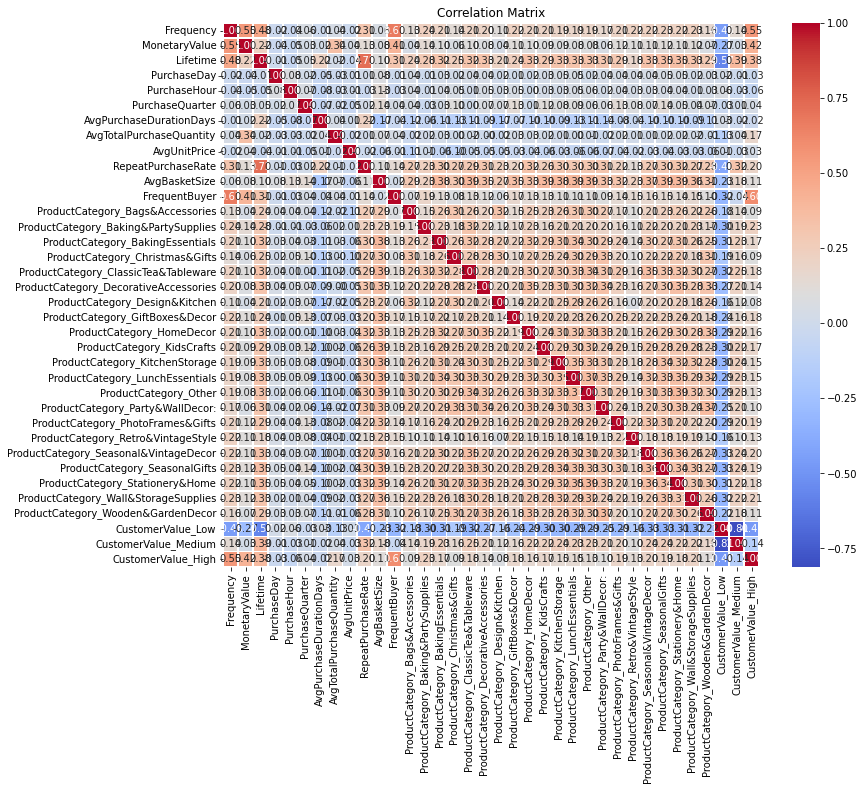

In [533]:
# df_cleaned.set_index('CustomerID', inplace=True)

# Calculate the correlation matrix
correlation_matrix = df_cleaned.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [534]:
# Create a mask to identify correlation coefficients above the threshold
# Note: Use abs() for absolute value to capture both strong positive and negative correlations
threshold = 0.8
highly_correlated = np.where(np.abs(correlation_matrix) > threshold)

# Extract pairs (excluding self-correlations where i == j)
highly_correlated_pairs = [(correlation_matrix.columns[x], correlation_matrix.columns[y]) 
                           for x, y in zip(*highly_correlated) if x != y and x < y]

# Optionally, convert pairs to a DataFrame for a more readable format
highly_correlated_df = pd.DataFrame(highly_correlated_pairs, columns=['Variable 1', 'Variable 2'])

print(highly_correlated_df)

          Variable 1            Variable 2
0  CustomerValue_Low  CustomerValue_Medium


## <center> 4. Scaling Features </center>
- Scaling ensures each feature contributes equally to distance calculations in K-means clustering, preventing features with larger ranges from dominating the algorithm.
- It improves the algorithm’s convergence speed and stability, leading to more accurate and interpretable clustering results.
- Also helps in PCA dimensionality reduction. PCA is based on maximizing variance. Features with larger magnitudes may end up dominating the variance, regardless of their actual importance in explaining the underlying structure of the data. Scaling brings all features to the same scale, ensuring that each feature's contribution to the overall variance is proportional to its importance.

In [535]:
df_cleaned.describe()

Frequency  MonetaryValue     Lifetime  PurchaseDay  PurchaseHour  \
count  4332.000000    4332.000000  4332.000000  4332.000000   4332.000000   
mean      4.243075    2015.005108   130.215605     2.543629     12.495845   
std       7.634623    8905.448637   132.073847     1.846121      2.317399   
min       1.000000       3.750000     0.000000     0.000000      7.000000   
25%       1.000000     304.172500     0.000000     1.000000     11.000000   
50%       2.000000     660.660000    91.500000     2.000000     12.000000   
75%       5.000000    1631.327500   252.000000     4.000000     14.000000   
max     206.000000  279138.020000   373.000000     6.000000     20.000000   

       PurchaseQuarter  AvgPurchaseDurationDays  AvgTotalPurchaseQuantity  \
count      4332.000000              4332.000000               4332.000000   
mean          2.877655                 3.191293                288.487827   
std           1.134171                10.443685               1256.642346   
min           1.000000                 0.000000                  1.000000   
25%           2.000000                 0.000000                101.645319   
50%           3.000000                 1.061925                180.038462   
75%           4.000000                 2.953078                311.164043   
max           4.000000               309.000000              74215.000000   

       AvgUnitPrice  RepeatPurchaseRate  AvgBasketSize  FrequentBuyer  \
count   4332.000000         4332.000000    4332.000000    4332.000000   
mean       3.441725            0.652585      25.669428       0.036934   
std        8.861882            0.476204      23.696235       0.188623   
min        0.122500            0.000000       1.000000       0.000000   
25%        2.144048            0.000000      10.836979       0.000000   
50%        2.818752            1.000000      19.625570       0.000000   
75%        3.679616            1.000000      32.474263       0.000000   
max      434.650000            1.000000     418.563886       1.000000   

       ProductCategory_Bags&Accessories  ProductCategory_Baking&PartySupplies  \
count                       4332.000000                           4332.000000   
mean                           0.873269                              0.277008   
std                            0.332710                              0.447572   
min                            0.000000                              0.000000   
25%                            1.000000                              0.000000   
50%                            1.000000                              0.000000   
75%                            1.000000                              1.000000   
max                            1.000000                              1.000000   

       ProductCategory_BakingEssentials  ProductCategory_Christmas&Gifts  \
count                       4332.000000                      4332.000000   
mean                           0.529778                         0.840720   
std                            0.499170                         0.365979   
min                            0.000000                         0.000000   
25%                            0.000000                         1.000000   
50%                            1.000000                         1.000000   
75%                            1.000000                         1.000000   
max                            1.000000                         1.000000   

       ProductCategory_ClassicTea&Tableware  \
count                           4332.000000   
mean                               0.518467   
std                                0.499717   
min                                0.000000   
25%                                0.000000   
50%                                1.000000   
75%                                1.000000   
max                                1.000000   

       ProductCategory_DecorativeAccessories  ProductCategory_Design&Kitchen  \
count                            4332.000000

In [536]:
# # df_pca_components = df_pca_components.drop(columns=['Cluster'])
# # df_scaled = df_scaled.drop(columns=['Cluster'])
# # df_cleaned = df_cleaned.drop(columns=['Cluster'])

# # Define the columns to be scaled
# # columns_to_scale = ['Recency', 'Frequency', 'MonetaryValue', 'Lifetime', 'PurchaseDay', 'PurchaseHour',
# #                     'PurchaseQuarter', 'AvgPurchaseDurationDays', 'AvgTotalPurchaseQuantity',
# #                     'AvgUnitPrice', 'AvgBasketSize']
#                     # , 'CancellationRecency', 'CancellationFrequency']
# columns_to_scale = [col for col in df_cleaned.columns if col != 'CustomerID']

# # Instantiate the StandardScaler
# # scaler = StandardScaler()

# # Copy the dataset
# df_scaled = df_cleaned.copy()

# # Fit and transform the selected columns
# scaler.fit(df_scaled[columns_to_scale])
# df_scaled[columns_to_scale] = scaler.transform(df_scaled[columns_to_scale])

# # df_scaled.set_index('CustomerID', inplace=True)

In [537]:
print(df_cleaned.shape)
# print(df_scaled.shape)

(4332, 36)


In [538]:
# df_scaled

## <center> 4. PCA Dimensionality Reduction </center>

[1.89202558e-01 1.10407155e-01 8.26109138e-02 6.87328699e-02
 6.69013227e-02 6.60627819e-02 6.22037030e-02 5.97742984e-02
 4.09055433e-02 2.21959163e-02 1.65137535e-02 1.40653373e-02
 1.33719797e-02 1.29456649e-02 1.28264271e-02 1.22198254e-02
 1.14614194e-02 1.10593773e-02 1.08084235e-02 1.07558278e-02
 1.02246339e-02 1.01635536e-02 9.77088702e-03 9.55908375e-03
 9.34822325e-03 9.06148963e-03 7.71052590e-03 7.28891670e-03
 7.01316124e-03 5.90960650e-03 5.34509863e-03 4.36468583e-03
 4.19066503e-03 3.98169337e-03 1.04267717e-03 3.73136253e-32]


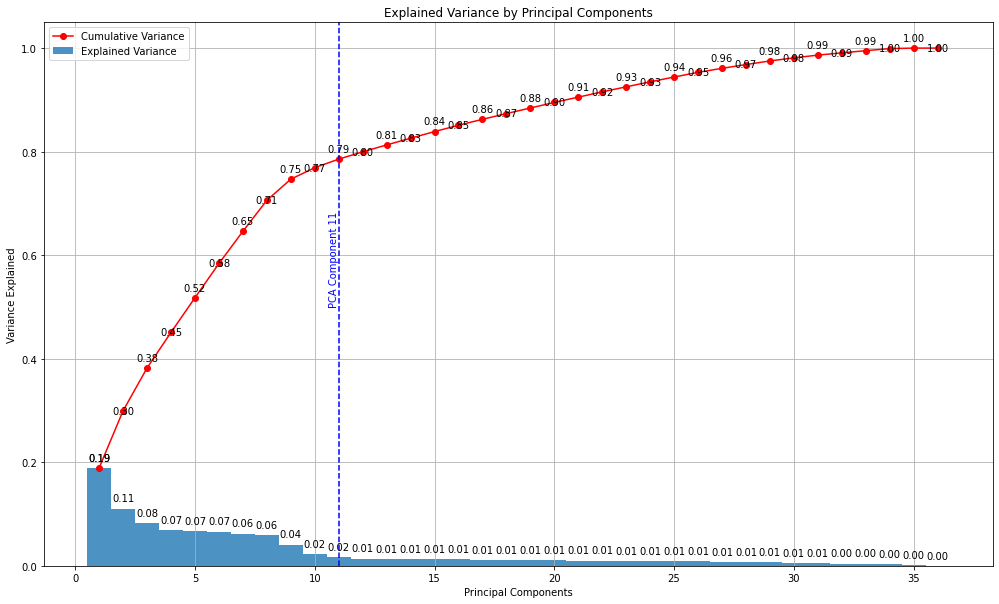

In [539]:
columns_to_scale = ['Frequency', 'MonetaryValue', 'Lifetime', 'PurchaseDay', 'PurchaseHour',
                    'PurchaseQuarter', 'AvgPurchaseDurationDays', 'AvgTotalPurchaseQuantity',
                    'AvgUnitPrice', 'AvgBasketSize']
# columns_to_scale = [col for col in df_cleaned.columns if col != 'CustomerID']
scaler = StandardScaler()
df_scaled = df_cleaned.copy()
df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])

pca = PCA().fit(df_scaled)

# Get explained variance for each component
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(explained_variance)
# print(explained_variance)

# print(cumulative_variance.shape)
# print(cumulative_variance)

# Plotting the explained variance by each component
plt.figure(figsize=(17, 10))
bars = plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.8, align='center', label='Explained Variance', width=1.0)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='r', label='Cumulative Variance')

# Adding values as text to the bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{explained_variance[i]:.2f}', ha='center', va='bottom')

# Adding values as text to the cumulative plot with adjusted positions
for i, cum_var in enumerate(cumulative_variance):
    plt.text(i + 1, cum_var + 0.01, f'{cum_var:.2f}', ha='center', va='bottom' if i % 2 == 0 else 'top')

# Draw a vertical line at principal component x value = 14
plt.axvline(x=11, color='b', linestyle='--')

# Label the line with the chosen PCA component
plt.text(11, 0.5, 'PCA Component 11', rotation=90, ha='right', va='bottom', color='b')

plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.grid(True)
plt.show()

- From the explained variance ratio, we observe diminishing returns in variance explained after the 11th component.
- Additionally, looking at the cumulative variance, we see that approximately 80% of the variance is explained by the first 11 components and then reached elbow point indicating that adding more components does not significantly increase the amount of explained variance.
- This indicates that choosing 11 components captures a significant portion of the variance in the dataset while avoiding the inclusion of redundant information.
- Hence, selecting 11 components strikes a balance between capturing variance and avoiding overfitting, making it a reasonable choice for dimensionality reduction in this scenario.

In [540]:
# df_pca_components = df_pca_components.drop(columns=['Cluster'])
# df_scaled = df_scaled.drop(columns=['Cluster'])

# Choose the number of components based on the explained variance ratios
# n_components = 14
n_components = 11

# Initialize PCA with the selected number of components
pca = PCA(n_components=n_components)

# columns_to_scale = ['Recency', 'Frequency', 'MonetaryValue', 'Lifetime', 'PurchaseDay', 'PurchaseHour',
#                     'PurchaseQuarter', 'AvgPurchaseDurationDays', 'AvgTotalPurchaseQuantity',
#                     'AvgUnitPrice', 'AvgBasketSize']
columns_to_scale = [col for col in df_cleaned.columns if col != 'CustomerID']
scaler = StandardScaler()
df_scaled = df_cleaned.copy()
df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])

# Fit PCA to the scaled data
pca.fit(df_scaled)

# Transform the data to the new PCA space
df_scaled_pca = pca.transform(df_scaled)

# Create a DataFrame with PCA components as columns
df_pca_components = pd.DataFrame(df_scaled_pca, index=df_scaled.index)
component_names = [f'PC{i+1}' for i in range(n_components)]
df_pca_components.columns = component_names

In [541]:
df_pca_components.shape

(4332, 11)

In [542]:
df_pca_components

PC1       PC2       PC3       PC4       PC5       PC6  \
CustomerID                                                               
17850       0.365817  6.305339 -1.993459 -0.984386 -0.574874 -0.888040   
13047       4.017110 -0.212806  2.128370  0.429350  1.300853 -0.896765   
12583       4.512537  1.676599 -0.429839 -0.444946 -0.712636  0.182441   
13748      -1.352172  1.069569  1.552117 -1.744557  0.244236 -0.111557   
15100      -4.825457  2.294653  1.407668  1.594135 -1.791052 -0.342798   
...              ...       ...       ...       ...       ...       ...   
13436      -1.766329 -0.055050 -1.246081  0.599180 -0.678250 -0.509356   
15520      -3.862500  0.982818 -0.602181  2.409264 -0.418419 -0.510267   
13298      -4.814904  1.190304 -0.515114  2.276817 -1.290548 -0.523466   
14569      -2.946097 -0.196141 -1.089036  0.425695 -0.437219  0.263657   
12713       0.181193 -1.644770 -1.706299  0.418376  0.028490  0.942035   

                 PC7       PC8       PC9      PC10      PC11  
CustomerID                                                    
17850      -2.261836  0.581964  0.187354 -2.040035 -0.465612  
13047      -0.445524  0.289983 -0.134008  0.463302 -0.358906  
12583      -0.148272  0.481494  0.367598 -1.185461  0.618056  
13748       0.479650 -1.672660  0.548610 -0.778530 -1.851958  
15100       0.852812 -0.977959  0.179068 -1.058034  0.119373  
...              ...       ...       ...       ...       ...  
13436      -0.368587 -0.760278 -0.649439 -0.752727 -0.284315  
15520       0.256446 -0.761939 -1.315766 -1.058499 -0.545268  
13298      -0.021400  0.191843  0.051579 -1.089236 -1.556994  
14569      -1.086692  0.050592  0.376393 -0.451640  0.122035  
12713      -0.481700  0.050562 -0.275828 -0.559686  1.949354  

[4332 rows x 11 columns]

## <center> 5. K-Means Clustering </center>

## 5.1 K-Means: Analysis on number of clusters
## K-Means vs K-Means++
- Standard K-means clustering can suffer from poor initialization, leading to suboptimal clustering results or slower convergence. The k-means++ algorithm addresses this issue by selecting initial centroids that are spread out and well-representative of the data points. This diversity in initial centroids helps in achieving a better distribution of clusters and reduces the likelihood of converging to local optima.
### Using Silhouette Scores

For n_clusters = 3 The average silhouette_score is : 0.27225749437348307
For n_clusters = 4 The average silhouette_score is : 0.2035084441542956
For n_clusters = 5 The average silhouette_score is : 0.1770437313010153
For n_clusters = 6 The average silhouette_score is : 0.17974419659520385
For n_clusters = 7 The average silhouette_score is : 0.1655707626957005
For n_clusters = 8 The average silhouette_score is : 0.16926493016041197
For n_clusters = 9 The average silhouette_score is : 0.1570742447535345
For n_clusters = 10 The average silhouette_score is : 0.16933449705890755


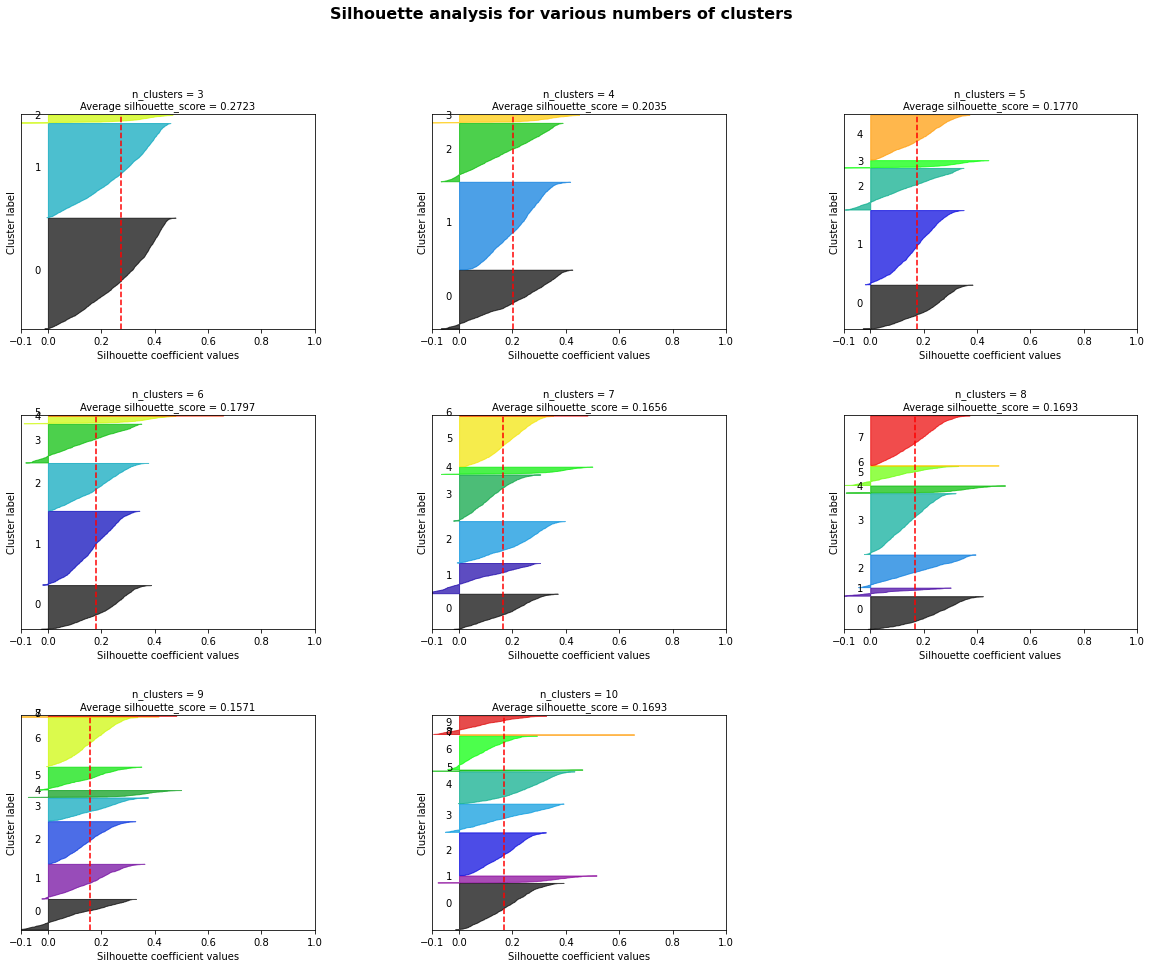

In [543]:
# df_pca_components = df_pca_components.drop(columns=['Cluster'])

range_n_clusters = list(range(3, 11))  # Clusters sizes from 3 to 10
n_rows = 3
n_cols = 3
silhouette_scores = []

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust space between plots

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

for idx, n_clusters in enumerate(range_n_clusters):
    ax1 = axes_flat[idx]
    
    # The silhouette coefficient can range from -1 to 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots
    ax1.set_ylim([0, len(df_pca_components) + (n_clusters + 1) * 10])
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, init='k-means++', max_iter=300)
    clusterer.fit(df_pca_components)
    cluster_labels = clusterer.predict(df_pca_components)
    # cluster_labels = clusterer.fit_predict(df_pca_components)
    
    silhouette_avg = silhouette_score(df_pca_components, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    sample_silhouette_values = silhouette_samples(df_pca_components, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples gap between clusters
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_title(f"n_clusters = {n_clusters}\nAverage silhouette_score = {silhouette_avg:.4f}", fontsize=10)
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    # Clear yticks for neatness
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# Hide any unused subplot axes if the number of plots is not a perfect square
for i in range(len(range_n_clusters), n_rows * n_cols):
    axes_flat[i].axis('off')

plt.suptitle("Silhouette analysis for various numbers of clusters", fontsize=16, fontweight='bold')
plt.show()


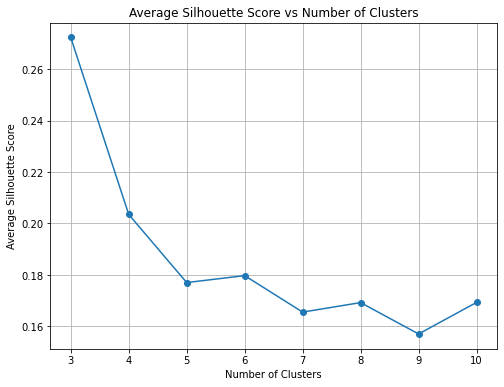

In [544]:
# Plotting silhouette_avg vs number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Score")
plt.title("Average Silhouette Score vs Number of Clusters")
plt.grid(True)
plt.show()

- The silhouette score is a measure of how similar an object is to its own cluster compared to other clusters. A higher silhouette score indicates better-defined clusters.
- Based on these scores, the optimal number of clusters appears to be 3 or 4, as it has the highest silhouette scores, indicating that the clusters are well-separated and points are closer to their own clusters than to neighboring clusters.

## 5.2 K-Means: Analysis on number of clusters - Using Elbow method
This method involves plotting the within-cluster sum of squares (WCSS) against the number of clusters and looking for the "elbow point," where the rate of decrease in WCSS slows down significantly, suggesting that adding more clusters does not significantly improve the fit of the model.

[91845.36412016518, 66546.25079099626, 58448.64138135991, 51457.99654402458, 47688.377771943546, 44582.47553931893, 42000.21605652323, 40163.45236076675, 37497.64425988174, 35580.49334300445]


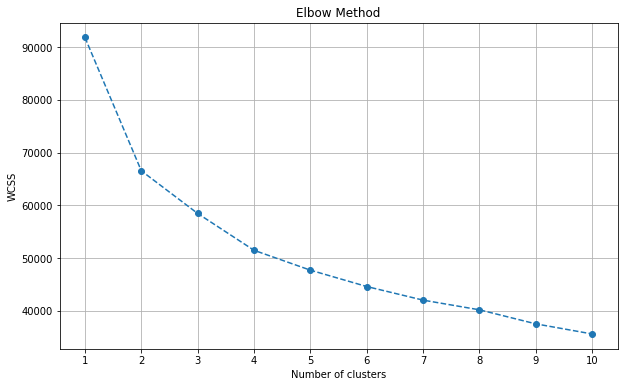

In [545]:
wcss = []  # Within cluster sum of squares
for i in range(1, 11):  # Trying different numbers of clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, random_state=10)
    kmeans.fit(df_pca_components)
    wcss.append(kmeans.inertia_)

print(wcss)
# Plotting the results onto a line graph to observe the 'elbow'
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


Based on the plot, the optimal number of clusters is typically located at the elbow point, which in this case appears to be around 3 or 4 clusters. Beyond this point, adding more clusters does not result in a significant reduction in WCSS, indicating diminishing returns.

## 5.3 K-Means Clustering
Based on both the elbow method and silhouette scores, the optimal number of clusters for the dataset appears to be 4, as it shows a clear "elbow" point in the within-cluster sum of squares plot and achieves the highest silhouette score, indicating well-defined and separated clusters.

In [546]:
# df_pca_components = df_pca_components.drop(columns=['Cluster'])
# df_scaled = df_scaled.drop(columns=['Cluster'])
# df_cleaned = df_cleaned.drop(columns=['Cluster_x', 'Cluster_y', 'Cluster'])
# df_cleaned = df_cleaned.drop(columns=['Cluster'])
# df_cleaned = df_cleaned.drop_duplicates()
df = df.drop_duplicates()

print(df_cleaned.shape)
print(df_pca_components.shape)
print(df.shape)

# Initialize the KMeans model
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=10, max_iter=300)

# Fit the model to the data
kmeans.fit(df_pca_components)

# Get the cluster labels for each data point
# labels = kmeans.labels_
labels = kmeans.predict(df_pca_components)
print(labels.shape)
cluster_df = pd.DataFrame(labels, index=df_cleaned.index, columns=['Cluster'])

# 3. Evaluate cluster quality using silhouette score
silhouette_avg = silhouette_score(df_pca_components, labels)
print(f"Silhouette Score: {silhouette_avg}") 

# Combine cluster labels with the datasets
df_cleaned['Cluster'] = cluster_df['Cluster']
df_pca_components['Cluster'] = labels
print(df_cleaned.shape)

# Display the count of customers in each cluster
print(df_cleaned['Cluster'].value_counts())
print(df_pca_components['Cluster'].value_counts())

# Analyze cluster characteristics using descriptive statistics of features in each cluster.
cluster_means = df_cleaned.groupby('Cluster').mean()
# print(cluster_means)


(4332, 36)
(4332, 11)
(391068, 28)
(4332,)
Silhouette Score: 0.2035084441542956
(4332, 37)
1    1786
0    1201
2    1193
3     152
Name: Cluster, dtype: int64
1    1786
0    1201
2    1193
3     152
Name: Cluster, dtype: int64


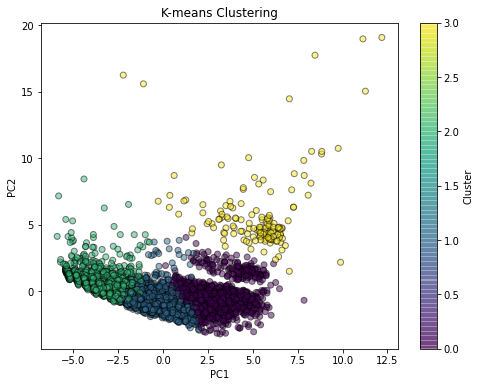

In [547]:
# Visualize the clusters (example with two features)
plt.figure(figsize=(8, 6))
plt.scatter(df_pca_components['PC1'], df_pca_components['PC2'], c=df_pca_components['Cluster'], cmap='viridis', alpha=0.5, edgecolors='k')
plt.title('K-means Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

In [548]:
df_cleaned.head(5)

Frequency  MonetaryValue  Lifetime  PurchaseDay  PurchaseHour  \
CustomerID                                                                  
17850              34        5391.21         1            3             9   
13047               9        3232.59       317            2            13   
12583              15        6705.38       370            4            12   
13748               5         948.25       278            0             9   
15100               3         876.00        40            2             9   

            PurchaseQuarter  AvgPurchaseDurationDays  \
CustomerID                                             
17850                     4                 0.000000   
13047                     2                 1.852941   
12583                     4                 1.575758   
13748                     3                10.259259   
15100                     4                19.500000   

            AvgTotalPurchaseQuantity  AvgUnitPrice  RepeatPurchaseRate  \
CustomerID                                                               
17850                      83.707071      3.960370                   1   
13047                     200.918129      3.926082                   1   
12583                     353.909483      2.140474                   1   
13748                     132.428571      3.996429                   1   
15100                      26.666667     10.950000                   1   

            AvgBasketSize  FrequentBuyer  ProductCategory_Bags&Accessories  \
CustomerID                                                                   
17850           14.414141              1                                 1   
13047           24.906433              0                                 1   
12583           16.982759              0                                 1   
13748            9.071429              0                                 0   
15100            1.000000              0                                 0   

            ProductCategory_Baking&PartySupplies  \
CustomerID                                         
17850                                          0   
13047                                          1   
12583                                          0   
13748                                          1   
15100                                          0   

            ProductCategory_BakingEssentials  ProductCategory_Christmas&Gifts  \
CustomerID                                                                      
17850                                      0                                0   
13047                                      1                                1   
12583                                      1                                1   
13748                                      0                                1   
15100                                      0                                0   

            ProductCategory_ClassicTea&Tableware  \
CustomerID                                         
17850                                          0   
13047                                          1   
12583                                          1   
13748                                          0   
15100                                          0   

            ProductCategory_DecorativeAccessories  \
CustomerID                                          
17850                                           1   
13047                                           1   
12583                                           1   
13748                                           1   
15100                                           0   

            ProductCategory_Design&Kitchen  ProductCategory_GiftBoxes&Decor  \
CustomerID                                                                    
17850                                    1                                0   
13047                                    1                                0   
12583                      

## 5.4 K-Means: Visualization

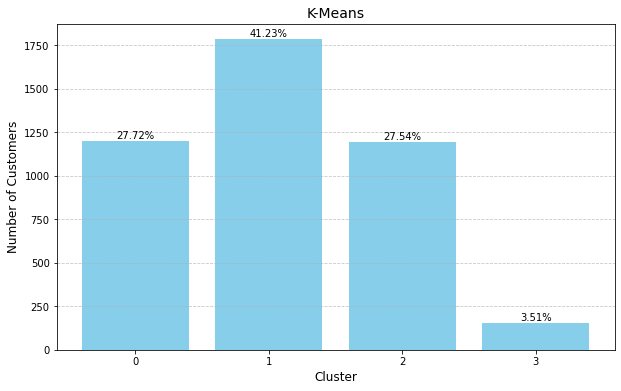

In [549]:
# Count the number of customers in each cluster
cluster_counts = df_pca_components['Cluster'].value_counts()

# Calculate the percentage of customers in each cluster
cluster_percentages = cluster_counts / len(df_pca_components) * 100

# Plotting the number of customers per cluster with percentage labels
plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')

# Adding percentage labels on top of each bar
for bar, percentage in zip(bars, cluster_percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 5, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=10)

# Adding labels and title
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.title('K-Means', fontsize=14)
plt.xticks(cluster_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## 5.5 K-Means: t-SNE Visualization

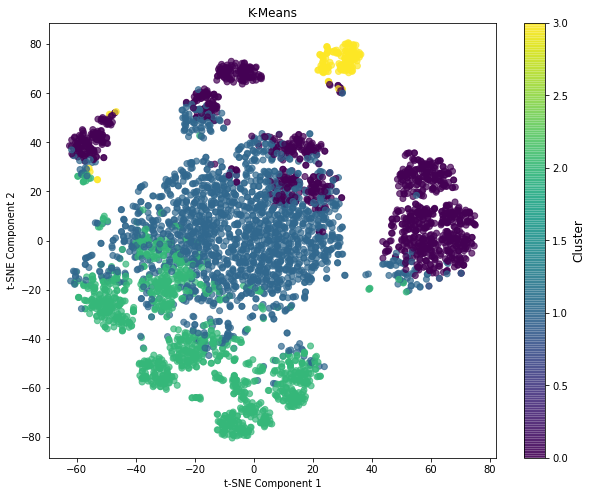

In [550]:
# Standardize the data before applying t-SNE
columns_to_scale = [col for col in df_cleaned.iloc[:, :-1].columns if col != 'CustomerID']
scaler = StandardScaler()
df_scaled = df_cleaned.iloc[:, :-1].copy()
df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])

# Apply t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=10)
tsne_components = tsne.fit_transform(df_scaled)

# Extract cluster labels from df_pca_components
cluster_labels = df_cleaned['Cluster']

# Plot t-SNE components colored by cluster
plt.figure(figsize=(10, 8))
plt.scatter(tsne_components[:, 0], tsne_components[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)

plt.title('K-Means')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Add color bar legend
cbar = plt.colorbar()
cbar.set_label('Cluster', fontsize=12)

plt.show()


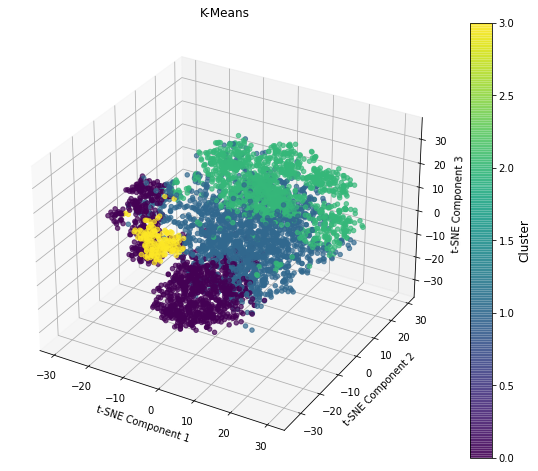

In [551]:
columns_to_scale = [col for col in df_cleaned.iloc[:, :-1].columns if col != 'CustomerID']
scaler = StandardScaler()
df_scaled = df_cleaned.iloc[:, :-1].copy()
df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])

# Extract the top 3 PCA components for visualization
# top_3_components = df_pca_components[['PC1', 'PC2', 'PC3']]

# Initialize t-SNE with 3 components and random state for reproducibility
tsne = TSNE(n_components=3, random_state=10)

# Fit t-SNE to the top 3 PCA components and transform them into a 3D space
# tsne_components = tsne.fit_transform(df_pca_components.iloc[:, :-1])
tsne_components = tsne.fit_transform(df_scaled)

# Create a 3D scatter plot of the t-SNE components colored by cluster labels
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract cluster labels from df_pca_components
cluster_labels = df_cleaned['Cluster']

# Plot t-SNE components in 3D with cluster labels as colors
scatter = ax.scatter(tsne_components[:, 0], tsne_components[:, 1], tsne_components[:, 2], c=cluster_labels, cmap='viridis', alpha=0.7)

# Add labels and title
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.set_title('K-Means')

# Add color bar legend
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster', fontsize=12)

# Show the plot
plt.show()


## 5.6 K-Means: Metrics Evaluation
- The silhouette score quantifies the compactness and separation of clusters. Higher values indicate better-defined clusters
- The Davies-Bouldin index evaluates the average similarity between clusters. Lower values indicate better clustering
- Inertia measures the sum of squared distances of samples to their closest cluster center. Lower inertia values indicate more compact clusters
- The Calinski-Harabasz index is a ratio of the sum of between-cluster dispersion to the sum of within-cluster dispersion. Higher values indicate better-defined, more separable clusters
- The Dunn index evaluates the compactness and separation of clusters based on intra-cluster and inter-cluster distances. Higher values indicate better clustering

In [552]:
# Compute silhouette score for KMeans clustering
silhouette_avg = silhouette_score(df_pca_components.iloc[:, :-1], df_pca_components['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

inertia = kmeans.inertia_
print(f"Inertia: {inertia}")

# Compute Davies-Bouldin index for KMeans clustering
db_index = davies_bouldin_score(df_pca_components.iloc[:, :-1], df_pca_components['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

# Compute Calinski-Harabasz index for clustering
ch_index = calinski_harabasz_score(df_pca_components.iloc[:, :-1], df_pca_components['Cluster'])
print(f"Calinski-Harabasz Index: {ch_index}")


Silhouette Score: 0.2035084441542956
Inertia: 51457.99654402458
Davies-Bouldin Index: 1.463955992110108
Calinski-Harabasz Index: 1132.3088565502999


## 5.7 K-Means: Cluster Visualization - Radar Charts

In [553]:
def plot_radar_chart_subplots(data, cluster_labels):
    # Scale the data (excluding the cluster column)
    scaler = StandardScaler()
    df_standard_scaled = scaler.fit_transform(data.drop(columns=['Cluster'], axis=1))

    df_standard_scaled = pd.DataFrame(df_standard_scaled, columns=data.columns[:-1], index=data.index)
    df_standard_scaled['Cluster'] = data['Cluster']

    num_clusters = len(cluster_labels)
    num_vars = df_standard_scaled.shape[1] - 1  # Exclude the 'Cluster' column
    categories = list(df_standard_scaled.drop('Cluster', axis=1).columns)

    # Define layout for subplots
    cols_per_row = 3  # Adjust based on preference
    rows = (num_clusters - 1) // cols_per_row + 1

    # Create a figure for subplots
    # fig, axs = plt.subplots(rows, cols_per_row, figsize=(16, 4 * rows), subplot_kw=dict(polar=True))
        
    
    # Create a figure with subplots for each cluster
    # fig, axes = plt.subplots(1, num_clusters, figsize=(24, 14), subplot_kw=dict(polar=True))
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(16, 4 * rows), subplot_kw=dict(polar=True))
    axes = axes.flatten() if num_clusters > 1 else [axes]  # Handle single-cluster subplot
    feature_names = df_standard_scaled.drop('Cluster', axis=1).columns.tolist()

    for i, cluster_label in enumerate(cluster_labels):
        # Extract data for the specified cluster
        cluster_data = df_standard_scaled[df_standard_scaled['Cluster'] == cluster_label].drop('Cluster', axis=1)
        # print(cluster_data)
        mean_values = cluster_data.mean().values
        
        # Scaled mean values
        mean_df = pd.DataFrame({'Feature': feature_names, 'MeanValue': mean_values})
        sorted_mean_df = mean_df.sort_values(by='MeanValue', ascending=False)
        print(f"Cluster {cluster_label} Features Sorted by Values:")
        for index, row in sorted_mean_df.iterrows():
            print(f"{row['Feature']}: {row['MeanValue']:.4f}")
        print()  # Print blank line for separation between clusters

        # Actual mean values
        mean_df = pd.DataFrame({'Feature': feature_names, 'MeanValue': data[data['Cluster'] == cluster_label].drop('Cluster', axis=1).mean().values})
        sorted_mean_df = mean_df.sort_values(by='MeanValue', ascending=False)
        print(f"Cluster {cluster_label} Features Sorted by Values:")
        for index, row in sorted_mean_df.iterrows():
            print(f"{row['Feature']}: {row['MeanValue']:.4f}")
        print()  # Print blank line for separation between clusters
    
        mean_values = np.concatenate([mean_values, mean_values[:1]])  # Close the circle
        
        # Calculate angles for radar chart
        angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]
        
        # Plot radar chart for the current cluster
        ax = axes[i]
        ax.fill(angles, mean_values, color='blue', alpha=0.25)
        ax.set_title(f"Cluster {cluster_label}", size=15, y=1.1)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, size=6)  # Rotate and align labels
        
        # Adjust layout and display the plot
        plt.subplots_adjust(wspace=0.5)  # Increase horizontal spacing between subplots

    # Hide unused subplot spaces if any
    for i in range(num_clusters, len(axes)):
        axes[i].axis('off')
        
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [554]:
df_cleaned.head()

Frequency  MonetaryValue  Lifetime  PurchaseDay  PurchaseHour  \
CustomerID                                                                  
17850              34        5391.21         1            3             9   
13047               9        3232.59       317            2            13   
12583              15        6705.38       370            4            12   
13748               5         948.25       278            0             9   
15100               3         876.00        40            2             9   

            PurchaseQuarter  AvgPurchaseDurationDays  \
CustomerID                                             
17850                     4                 0.000000   
13047                     2                 1.852941   
12583                     4                 1.575758   
13748                     3                10.259259   
15100                     4                19.500000   

            AvgTotalPurchaseQuantity  AvgUnitPrice  RepeatPurchaseRate  \
CustomerID                                                               
17850                      83.707071      3.960370                   1   
13047                     200.918129      3.926082                   1   
12583                     353.909483      2.140474                   1   
13748                     132.428571      3.996429                   1   
15100                      26.666667     10.950000                   1   

            AvgBasketSize  FrequentBuyer  ProductCategory_Bags&Accessories  \
CustomerID                                                                   
17850           14.414141              1                                 1   
13047           24.906433              0                                 1   
12583           16.982759              0                                 1   
13748            9.071429              0                                 0   
15100            1.000000              0                                 0   

            ProductCategory_Baking&PartySupplies  \
CustomerID                                         
17850                                          0   
13047                                          1   
12583                                          0   
13748                                          1   
15100                                          0   

            ProductCategory_BakingEssentials  ProductCategory_Christmas&Gifts  \
CustomerID                                                                      
17850                                      0                                0   
13047                                      1                                1   
12583                                      1                                1   
13748                                      0                                1   
15100                                      0                                0   

            ProductCategory_ClassicTea&Tableware  \
CustomerID                                         
17850                                          0   
13047                                          1   
12583                                          1   
13748                                          0   
15100                                          0   

            ProductCategory_DecorativeAccessories  \
CustomerID                                          
17850                                           1   
13047                                           1   
12583                                           1   
13748                                           1   
15100                                           0   

            ProductCategory_Design&Kitchen  ProductCategory_GiftBoxes&Decor  \
CustomerID                                                                    
17850                                    1                                0   
13047                                    1                                0   
12583                      

Cluster 0 Features Sorted by Values:
CustomerValue_Medium: 1.0469
Lifetime: 0.8114
ProductCategory_SeasonalGifts: 0.7259
AvgBasketSize: 0.7119
ProductCategory_Seasonal&VintageDecor: 0.7058
ProductCategory_ClassicTea&Tableware: 0.6971
ProductCategory_Stationery&Home: 0.6840
ProductCategory_Wall&StorageSupplies: 0.6820
RepeatPurchaseRate: 0.6702
ProductCategory_KitchenStorage: 0.6684
ProductCategory_Other: 0.6659
ProductCategory_LunchEssentials: 0.6420
ProductCategory_BakingEssentials: 0.6418
ProductCategory_KidsCrafts: 0.6297
ProductCategory_PhotoFrames&Gifts: 0.6080
ProductCategory_HomeDecor: 0.6051
ProductCategory_DecorativeAccessories: 0.6016
ProductCategory_Party&WallDecor:: 0.5385
ProductCategory_GiftBoxes&Decor: 0.5244
ProductCategory_Baking&PartySupplies: 0.4880
ProductCategory_Wooden&GardenDecor: 0.4852
ProductCategory_Christmas&Gifts: 0.4148
ProductCategory_Bags&Accessories: 0.3734
ProductCategory_Retro&VintageStyle: 0.3504
ProductCategory_Design&Kitchen: 0.3207
Frequency: 0.25

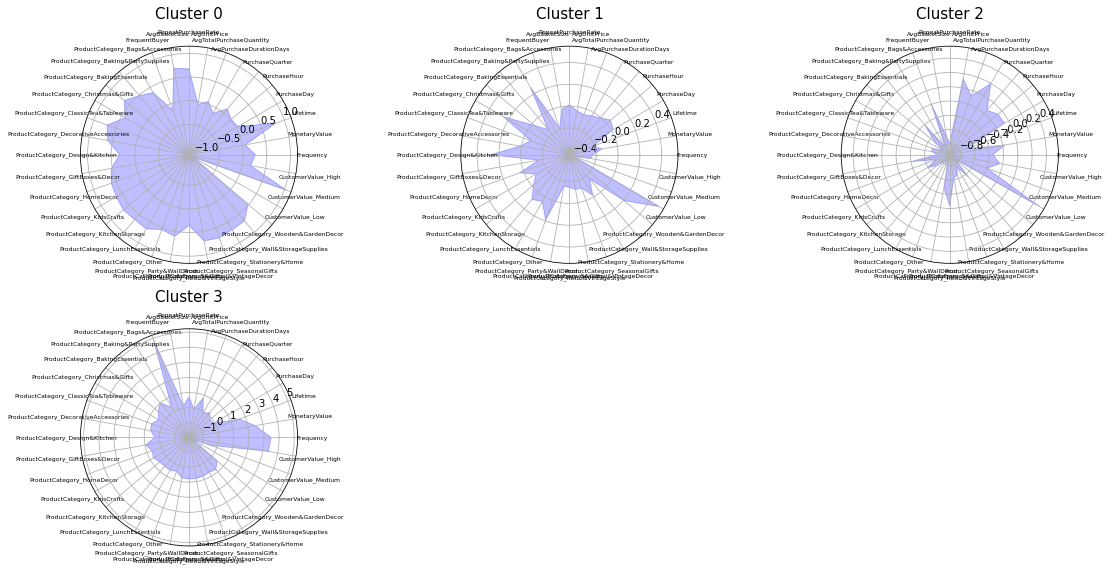

In [555]:
# Plot radar charts for each cluster (e.g., Cluster 0, Cluster 1, Cluster 2) for original dataframe
# cluster_labels = [0, 1, 2]  # Specify the cluster labels to plot

# # Scale the data (excluding the cluster column)
# scaler = StandardScaler()
# df_standard_scaled = scaler.fit_transform(df_cleaned.drop(columns=['Cluster'], axis=1))

# df_standard_scaled = pd.DataFrame(df_standard_scaled, columns=df_cleaned.columns[:-1], index=df_cleaned.index)
# df_standard_scaled['Cluster'] = df_cleaned['Cluster']

cluster_labels = [0, 1, 2, 3]  # Specify the cluster labels to plot
plot_radar_chart_subplots(df_cleaned, cluster_labels)

# plot_cluster_radar_charts(df_standard_scaled)

## 5.8 K-Means: Cluster Visualization - Histogram Plots

In [556]:
def plot_feature_vs_clusters(data, cluster_labels):
    # Extract unique cluster labels
    unique_clusters = sorted(data['Cluster'].unique())
    
    # Initialize the number of rows and columns for subplots
    num_features = len(data.columns) - 1  # Exclude 'Cluster' column
    num_clusters = len(unique_clusters)
    num_rows = num_features
    num_cols = num_clusters
    
    # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_features))
    
    # Plot histograms for each feature vs. clusters
    for i, feature in enumerate(data.columns[:-1]):  # Exclude 'Cluster' column
        for j, cluster in enumerate(unique_clusters):
            ax = axes[i, j] if num_features > 1 else axes[j]  # Handle single-row subplot
            # sns.histplot(data[data['Cluster'] == cluster][feature], kde=True, ax=ax)
            sns.histplot(data[data['Cluster'] == cluster][feature], element='bars', ax=ax)
            ax.set_title(f"Cluster {cluster}")
            ax.set_xlabel(feature)
            ax.set_ylabel('Frequency')
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [557]:
# Plot feature vs. clusters histogram plots for original dataframe
# plot_feature_vs_clusters(df_cleaned, df_cleaned['Cluster'])

## 5.9 K-Means: Random Forest Feature Selection

(4332, 37)


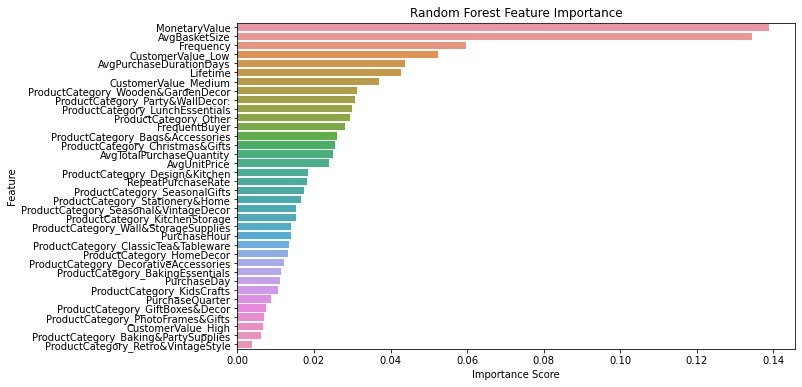

In [558]:
# Scale the data (excluding the cluster column)
print(df_cleaned.shape)
scaler = StandardScaler()
df_standard_scaled = scaler.fit_transform(df_cleaned.drop(columns=['Cluster'], axis=1))

df_standard_scaled = pd.DataFrame(df_standard_scaled, columns=df_cleaned.columns[:-1], index=df_cleaned.index)
df_standard_scaled['Cluster'] = df_cleaned['Cluster']


# Split data into features (X) and target (y)
X = df_standard_scaled.drop('Cluster', axis=1)  # Exclude the 'Cluster' column
y = df_standard_scaled['Cluster']

# Initialize Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the data
rf.fit(X, y)

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


## 5.10 K-Means: Random Forest Cluster Visualization - Radar Charts

Cluster 0 Features Sorted by Values:
CustomerValue_Medium: 1.0469
Lifetime: 0.8114
ProductCategory_SeasonalGifts: 0.7259
AvgBasketSize: 0.7119
ProductCategory_Stationery&Home: 0.6840
RepeatPurchaseRate: 0.6702
ProductCategory_Other: 0.6659
ProductCategory_LunchEssentials: 0.6420
ProductCategory_Party&WallDecor:: 0.5385
ProductCategory_Wooden&GardenDecor: 0.4852
ProductCategory_Christmas&Gifts: 0.4148
ProductCategory_Bags&Accessories: 0.3734
ProductCategory_Design&Kitchen: 0.3207
Frequency: 0.2584
MonetaryValue: 0.0649
AvgTotalPurchaseQuantity: 0.0538
AvgUnitPrice: -0.0625
AvgPurchaseDurationDays: -0.1300
FrequentBuyer: -0.1429
CustomerValue_Low: -1.0396

Cluster 0 Features Sorted by Values:
MonetaryValue: 2592.8545
AvgTotalPurchaseQuantity: 356.1172
Lifetime: 237.3705
AvgBasketSize: 42.5361
Frequency: 6.2157
AvgUnitPrice: 2.8879
AvgPurchaseDurationDays: 1.8336
ProductCategory_Design&Kitchen: 0.9983
ProductCategory_Bags&Accessories: 0.9975
ProductCategory_Christmas&Gifts: 0.9925
Product

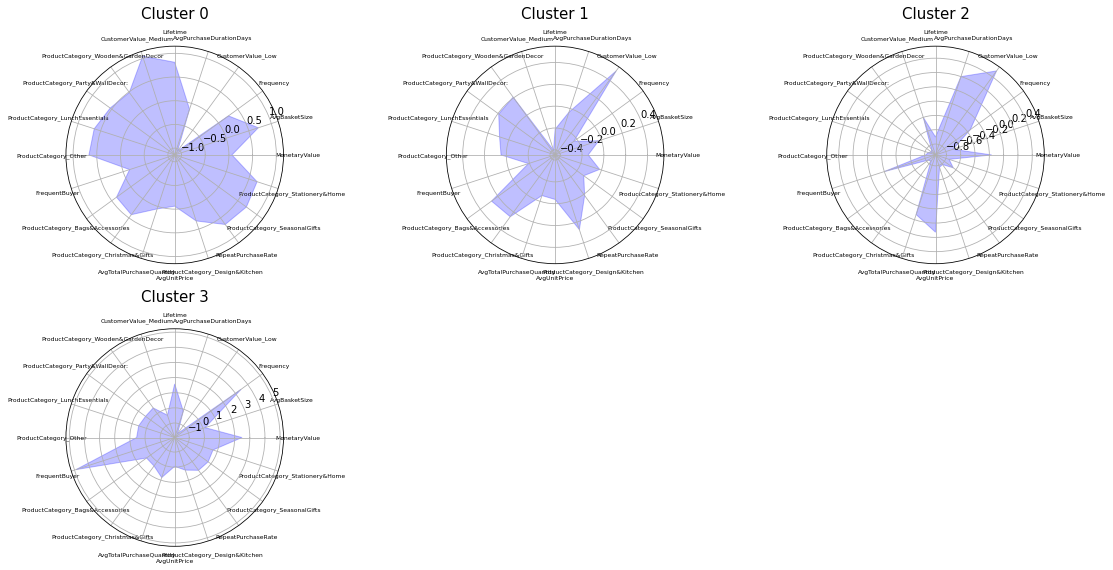

In [559]:
# Plot radar charts for each cluster (e.g., Cluster 0, Cluster 1, Cluster 2) for top 10 RF features
# Sort features by importance
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)['Feature'].tolist()

# Filter dataset to select only top features and 'Cluster' column
df_selected = df_cleaned[top_features + ['Cluster']]

cluster_labels = [0, 1, 2, 3]  # Specify the cluster labels to plot
plot_radar_chart_subplots(df_selected, cluster_labels)

In [560]:
df_selected.groupby('Cluster').mean()

MonetaryValue  AvgBasketSize  Frequency  CustomerValue_Low  \
Cluster                                                               
0          2592.854455      42.536142   6.215654           0.269775   
1           738.713387      25.045135   2.455767           0.954647   
2           523.726262       9.159569   1.562448           0.952221   
3         24150.239408      29.316323  30.697368           0.006579   

         AvgPurchaseDurationDays    Lifetime  CustomerValue_Medium  \
Cluster                                                              
0                       1.833556  237.370525              0.609492   
1                       2.830329  102.218365              0.035834   
2                       5.265884   37.601006              0.036044   
3                       1.877706  339.421053              0.032895   

         ProductCategory_Wooden&GardenDecor  ProductCategory_Party&WallDecor:  \
Cluster                                                                         
0                                  0.965862                          0.978351   
1                                  0.847144                          0.826988   
2                                  0.390612                          0.357083   
3                                  0.953947                          0.927632   

         ProductCategory_LunchEssentials  ProductCategory_Other  \
Cluster                                                           
0                               0.949209               0.916736   
1                               0.683651               0.613102   
2                               0.234702               0.188600   
3                               0.901316               0.861842   

         FrequentBuyer  ProductCategory_Bags&Accessories  \
Cluster                                                    
0             0.009992                          0.997502   
1             0.001120                          0.964166   
2             0.000000                          0.597653   
3             0.960526                          0.986842   

         ProductCategory_Christmas&Gifts  AvgTotalPurchaseQuantity  \
Cluster                                                              
0                               0.992506                356.117182   
1                               0.933371                219.067630   
2                               0.532272                192.822758   
3                               0.973684               1320.659177   

         AvgUnitPrice  ProductCategory_Design&Kitchen  RepeatPurchaseRate  \
Cluster                                                                     
0            2.887901                        0.998335            0.971690   
1            3.098083                        0.984323            0.659015   
2            4.578608                        0.676446            0.278290   
3            2.932413                        0.993421            0.993421   

         ProductCategory_SeasonalGifts  ProductCategory_Stationery&Home  
Cluster                                                                  
0                             0.773522                         0.853455  
1                             0.355543                         0.502800  
2                             0.097234                         0.135792  
3                             0.796053                         0.861842

## 5.11 K-Means: Random Forest Cluster Visualization - Histogram Plots

In [561]:
# Plot feature vs. clusters histogram plots for original dataframe
# plot_feature_vs_clusters(df_selected, df_selected['Cluster'])

## <center> 6. Hierarchical Clustering </center>

## 6.1 Hierarchical: Analysis on number of clusters
### Using Dendogram plot

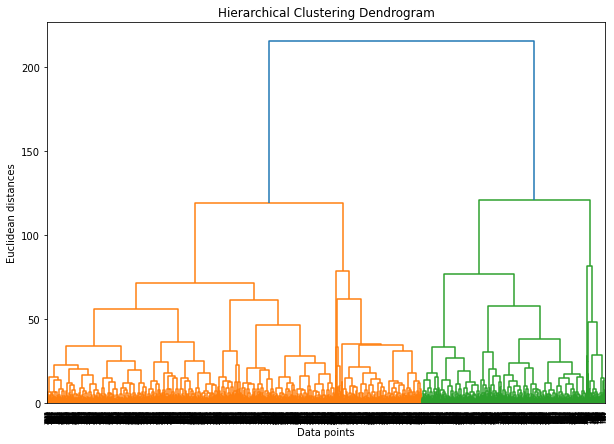

In [562]:
df_cleaned = df_cleaned.drop(columns=['Cluster'])
df_pca_components = df_pca_components.drop(columns=['Cluster'])

# Sclaing
# columns_to_scale = ['Recency', 'Frequency', 'MonetaryValue', 'Lifetime', 'PurchaseDay', 'PurchaseHour',
                    # 'PurchaseQuarter', 'AvgPurchaseDurationDays', 'AvgTotalPurchaseQuantity',
                    # 'AvgUnitPrice', 'AvgBasketSize']
# columns_to_scale = [col for col in df_cleaned.columns if col != 'CustomerID']
# scaler = StandardScaler()
# df_scaled = df_cleaned.copy()
# df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])

# Generate the linkage matrix
Z = sch.linkage(df_pca_components, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Euclidean distances')
plt.show()


### 6.2 Using Silhouette Scores

For n_clusters = 2 The average silhouette_score is : 0.27690796657150574
For n_clusters = 3 The average silhouette_score is : 0.26575256297208344
For n_clusters = 4 The average silhouette_score is : 0.19416615564040626
For n_clusters = 5 The average silhouette_score is : 0.19531013809337344
For n_clusters = 6 The average silhouette_score is : 0.19359779792836096
For n_clusters = 7 The average silhouette_score is : 0.14877603122666683
For n_clusters = 8 The average silhouette_score is : 0.12174557571194877
For n_clusters = 9 The average silhouette_score is : 0.1263498882252718
For n_clusters = 10 The average silhouette_score is : 0.12343161260875708


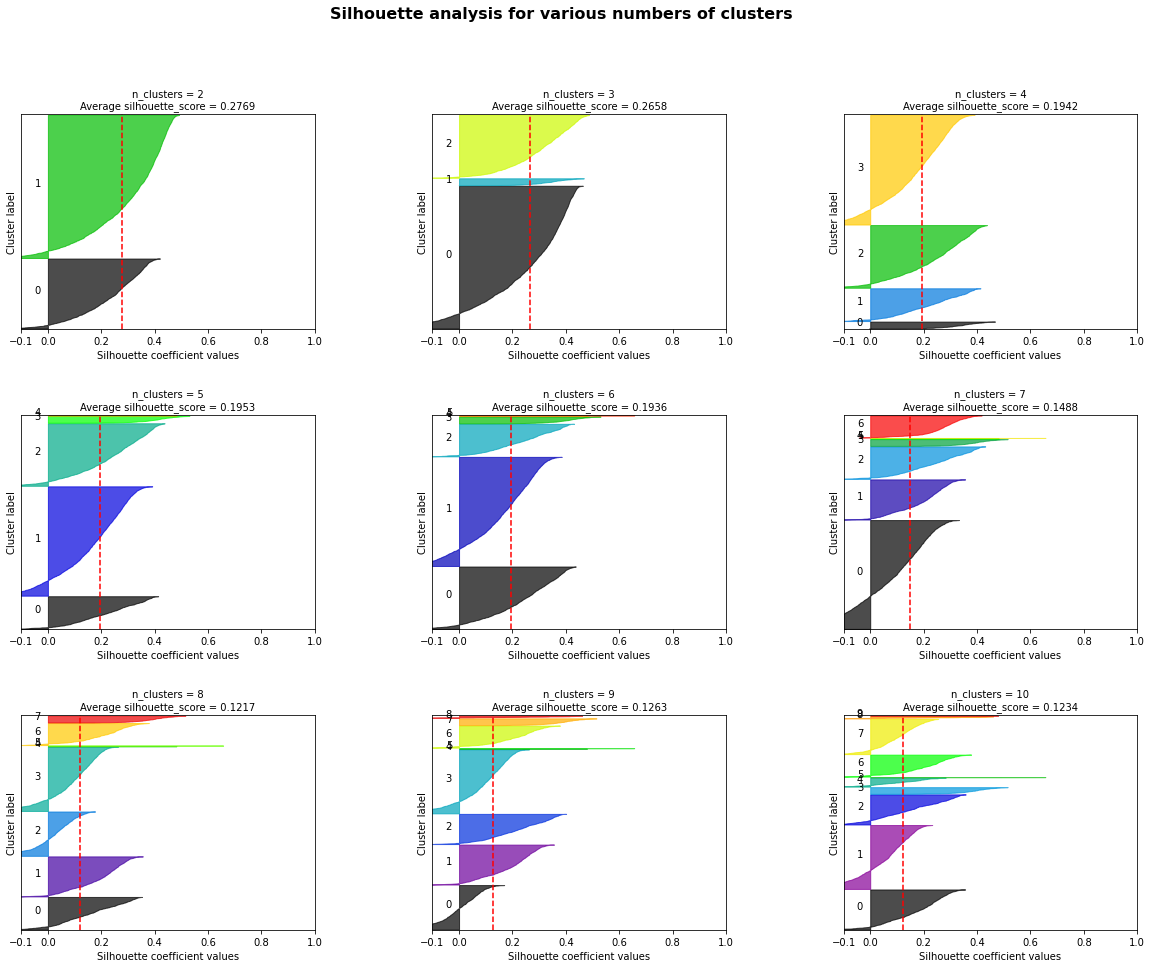

In [563]:
range_n_clusters = list(range(2, 11))  # Clusters sizes from 2 to 10
n_rows = 3
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust space between plots

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

for idx, n_clusters in enumerate(range_n_clusters):
    ax1 = axes_flat[idx]
    
    # The silhouette coefficient can range from -1 to 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots
    ax1.set_ylim([0, len(df_pca_components) + (n_clusters + 1) * 10])
    
    # clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    clusterer = AgglomerativeClustering(n_clusters = n_clusters, affinity = 'euclidean', linkage = 'ward')
    cluster_labels = clusterer.fit_predict(df_pca_components)
    # cluster_labels = clusterer.fit_predict(df_pca_components)
    
    silhouette_avg = silhouette_score(df_pca_components, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    sample_silhouette_values = silhouette_samples(df_pca_components, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples gap between clusters
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_title(f"n_clusters = {n_clusters}\nAverage silhouette_score = {silhouette_avg:.4f}", fontsize=10)
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    # Clear yticks for neatness
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# Hide any unused subplot axes if the number of plots is not a perfect square
for i in range(len(range_n_clusters), n_rows * n_cols):
    axes_flat[i].axis('off')

plt.suptitle("Silhouette analysis for various numbers of clusters", fontsize=16, fontweight='bold')
plt.show()


## 6.3 Hierarchical Clustering
The optimal number of clusters for the dataset, determined from both the dendrogram and silhouette analysis, is 4. This choice is supported by the highest silhouette score and clear separation of clusters observed through horizontal cut.

In [564]:
# df_pca_components = df_pca_components.drop(columns=['Cluster'])
# df_cleaned = df_cleaned.drop(columns=['Cluster_x', 'Cluster_y', 'Cluster'])
# df_cleaned = df_cleaned.drop(columns=['Cluster'])
# df_scaled = df_scaled.drop(columns=['Cluster'])
# df_cleaned = df_cleaned.drop_duplicates()

print(df_cleaned.shape)
print(df_pca_components.shape)
print(df_pca_components.shape)
print(df.shape)

# Initialize the model
agg_clustering = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')

# Fit the model to the data
labels = agg_clustering.fit_predict(df_pca_components)
print(labels.shape)
cluster_df = pd.DataFrame(labels, index=df_cleaned.index, columns=['Cluster'])

# 3. Evaluate cluster quality using silhouette score
silhouette_avg = silhouette_score(df_pca_components, labels)
print(f"Silhouette Score: {silhouette_avg}") 

# Combine cluster labels with the datasets
df_cleaned['Cluster'] = cluster_df['Cluster']
df_pca_components['Cluster'] = labels
print(df_cleaned.shape)

# Display the count of customers in each cluster
print(df_cleaned['Cluster'].value_counts())
print(df_pca_components['Cluster'].value_counts())

# Analyze cluster characteristics using descriptive statistics of features in each cluster.
cluster_means = df_cleaned.groupby('Cluster').mean()
# print(cluster_means)

(4332, 36)
(4332, 11)
(4332, 11)
(391068, 28)
(4332,)
Silhouette Score: 0.19416615564040626
(4332, 37)
3    2239
2    1281
1     670
0     142
Name: Cluster, dtype: int64
3    2239
2    1281
1     670
0     142
Name: Cluster, dtype: int64


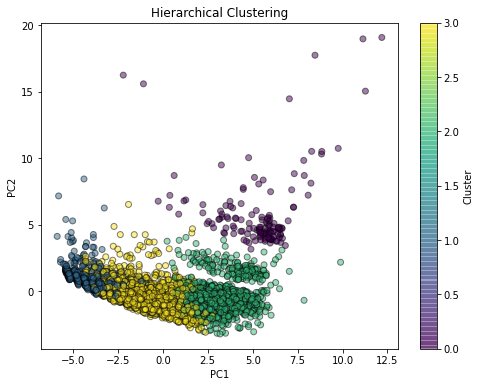

In [565]:
# Visualize the clusters (example with two features)
plt.figure(figsize=(8, 6))
plt.scatter(df_pca_components['PC1'], df_pca_components['PC2'], c=df_pca_components['Cluster'], cmap='viridis', alpha=0.5, edgecolors='k')
plt.title('Hierarchical Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

In [566]:
df_cleaned.head(5)

Frequency  MonetaryValue  Lifetime  PurchaseDay  PurchaseHour  \
CustomerID                                                                  
17850              34        5391.21         1            3             9   
13047               9        3232.59       317            2            13   
12583              15        6705.38       370            4            12   
13748               5         948.25       278            0             9   
15100               3         876.00        40            2             9   

            PurchaseQuarter  AvgPurchaseDurationDays  \
CustomerID                                             
17850                     4                 0.000000   
13047                     2                 1.852941   
12583                     4                 1.575758   
13748                     3                10.259259   
15100                     4                19.500000   

            AvgTotalPurchaseQuantity  AvgUnitPrice  RepeatPurchaseRate  \
CustomerID                                                               
17850                      83.707071      3.960370                   1   
13047                     200.918129      3.926082                   1   
12583                     353.909483      2.140474                   1   
13748                     132.428571      3.996429                   1   
15100                      26.666667     10.950000                   1   

            AvgBasketSize  FrequentBuyer  ProductCategory_Bags&Accessories  \
CustomerID                                                                   
17850           14.414141              1                                 1   
13047           24.906433              0                                 1   
12583           16.982759              0                                 1   
13748            9.071429              0                                 0   
15100            1.000000              0                                 0   

            ProductCategory_Baking&PartySupplies  \
CustomerID                                         
17850                                          0   
13047                                          1   
12583                                          0   
13748                                          1   
15100                                          0   

            ProductCategory_BakingEssentials  ProductCategory_Christmas&Gifts  \
CustomerID                                                                      
17850                                      0                                0   
13047                                      1                                1   
12583                                      1                                1   
13748                                      0                                1   
15100                                      0                                0   

            ProductCategory_ClassicTea&Tableware  \
CustomerID                                         
17850                                          0   
13047                                          1   
12583                                          1   
13748                                          0   
15100                                          0   

            ProductCategory_DecorativeAccessories  \
CustomerID                                          
17850                                           1   
13047                                           1   
12583                                           1   
13748                                           1   
15100                                           0   

            ProductCategory_Design&Kitchen  ProductCategory_GiftBoxes&Decor  \
CustomerID                                                                    
17850                                    1                                0   
13047                                    1                                0   
12583                      

## 6.4 Hierarchical: Visualization

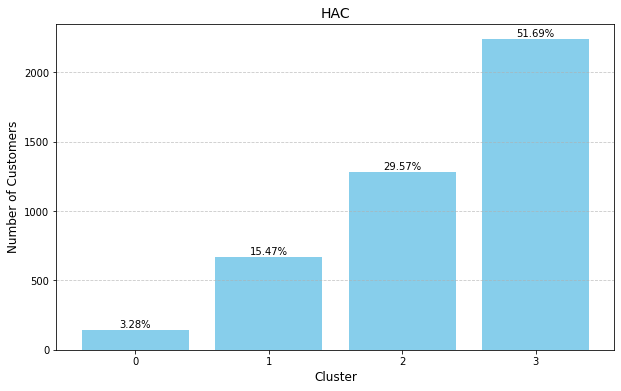

In [567]:
# Count the number of customers in each cluster
cluster_counts = df_pca_components['Cluster'].value_counts()

# Calculate the percentage of customers in each cluster
cluster_percentages = cluster_counts / len(df_pca_components) * 100

# Plotting the number of customers per cluster with percentage labels
plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')

# Adding percentage labels on top of each bar
for bar, percentage in zip(bars, cluster_percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 5, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=10)

# Adding labels and title
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.title('HAC', fontsize=14)
plt.xticks(cluster_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## 6.5 Hierarchical: t-SNE Visualization

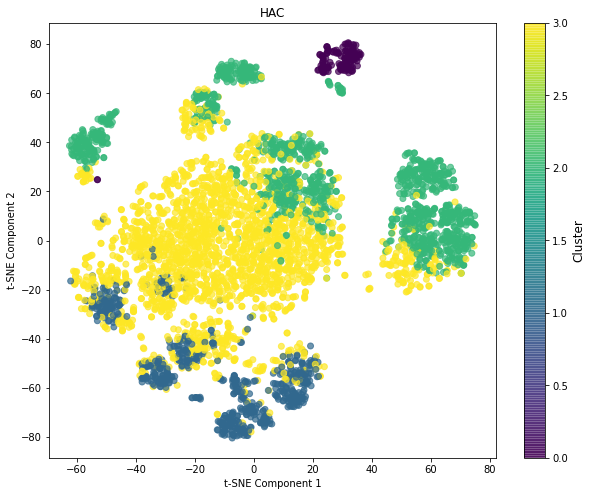

In [568]:
# Standardize the data before applying t-SNE
columns_to_scale = [col for col in df_cleaned.iloc[:, :-1].columns if col != 'CustomerID']
scaler = StandardScaler()
df_scaled = df_cleaned.iloc[:, :-1].copy()
df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])

# Apply t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=10)
tsne_components = tsne.fit_transform(df_scaled)

# Extract cluster labels from df_pca_components
cluster_labels = df_cleaned['Cluster']

# Plot t-SNE components colored by cluster
plt.figure(figsize=(10, 8))
plt.scatter(tsne_components[:, 0], tsne_components[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)

plt.title('HAC')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Add color bar legend
cbar = plt.colorbar()
cbar.set_label('Cluster', fontsize=12)

plt.show()


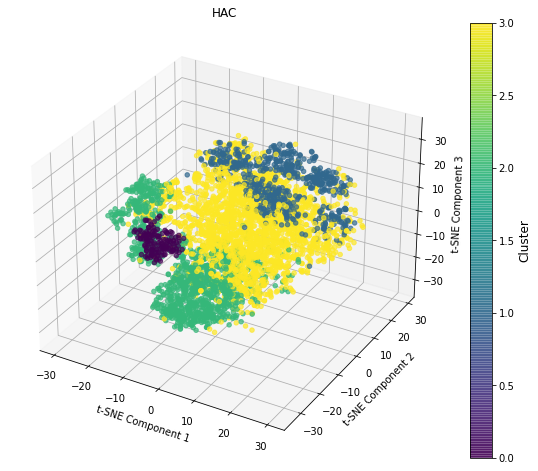

In [569]:
columns_to_scale = [col for col in df_cleaned.iloc[:, :-1].columns if col != 'CustomerID']
scaler = StandardScaler()
df_scaled = df_cleaned.iloc[:, :-1].copy()
df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])

# Extract the top 3 PCA components for visualization
# top_3_components = df_pca_components[['PC1', 'PC2', 'PC3']]

# Initialize t-SNE with 3 components and random state for reproducibility
tsne = TSNE(n_components=3, random_state=10)

# Fit t-SNE to the top 3 PCA components and transform them into a 3D space
# tsne_components = tsne.fit_transform(df_pca_components.iloc[:, :-1])
tsne_components = tsne.fit_transform(df_scaled)

# Create a 3D scatter plot of the t-SNE components colored by cluster labels
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract cluster labels from df_pca_components
cluster_labels = df_cleaned['Cluster']

# Plot t-SNE components in 3D with cluster labels as colors
scatter = ax.scatter(tsne_components[:, 0], tsne_components[:, 1], tsne_components[:, 2], c=cluster_labels, cmap='viridis', alpha=0.7)

# Add labels and title
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.set_title('HAC')

# Add color bar legend
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster', fontsize=12)

# Show the plot
plt.show()


## 6.6 Hierarchical: Metrics Evaluation
- The silhouette score quantifies the compactness and separation of clusters. Higher values indicate better-defined clusters
- The Davies-Bouldin index evaluates the average similarity between clusters. Lower values indicate better clustering
- Inertia measures the sum of squared distances of samples to their closest cluster center. Lower inertia values indicate more compact clusters
- The Calinski-Harabasz index is a ratio of the sum of between-cluster dispersion to the sum of within-cluster dispersion. Higher values indicate better-defined, more separable clusters
- The Dunn index evaluates the compactness and separation of clusters based on intra-cluster and inter-cluster distances. Higher values indicate better clustering

In [570]:
# Compute silhouette score for clustering
silhouette_avg = silhouette_score(df_pca_components.iloc[:, :-1], df_pca_components['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

# Compute Davies-Bouldin index for clustering
db_index = davies_bouldin_score(df_pca_components.iloc[:, :-1], df_pca_components['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

# Compute Calinski-Harabasz index for clustering
ch_index = calinski_harabasz_score(df_pca_components.iloc[:, :-1], df_pca_components['Cluster'])
print(f"Calinski-Harabasz Index: {ch_index}")


Silhouette Score: 0.19416615564040626
Davies-Bouldin Index: 1.447317647769898
Calinski-Harabasz Index: 1009.0191804268563


## 6.7 Hierarchical: Cluster Visualization - Radar Charts

In [571]:
df_cleaned.head()

Frequency  MonetaryValue  Lifetime  PurchaseDay  PurchaseHour  \
CustomerID                                                                  
17850              34        5391.21         1            3             9   
13047               9        3232.59       317            2            13   
12583              15        6705.38       370            4            12   
13748               5         948.25       278            0             9   
15100               3         876.00        40            2             9   

            PurchaseQuarter  AvgPurchaseDurationDays  \
CustomerID                                             
17850                     4                 0.000000   
13047                     2                 1.852941   
12583                     4                 1.575758   
13748                     3                10.259259   
15100                     4                19.500000   

            AvgTotalPurchaseQuantity  AvgUnitPrice  RepeatPurchaseRate  \
CustomerID                                                               
17850                      83.707071      3.960370                   1   
13047                     200.918129      3.926082                   1   
12583                     353.909483      2.140474                   1   
13748                     132.428571      3.996429                   1   
15100                      26.666667     10.950000                   1   

            AvgBasketSize  FrequentBuyer  ProductCategory_Bags&Accessories  \
CustomerID                                                                   
17850           14.414141              1                                 1   
13047           24.906433              0                                 1   
12583           16.982759              0                                 1   
13748            9.071429              0                                 0   
15100            1.000000              0                                 0   

            ProductCategory_Baking&PartySupplies  \
CustomerID                                         
17850                                          0   
13047                                          1   
12583                                          0   
13748                                          1   
15100                                          0   

            ProductCategory_BakingEssentials  ProductCategory_Christmas&Gifts  \
CustomerID                                                                      
17850                                      0                                0   
13047                                      1                                1   
12583                                      1                                1   
13748                                      0                                1   
15100                                      0                                0   

            ProductCategory_ClassicTea&Tableware  \
CustomerID                                         
17850                                          0   
13047                                          1   
12583                                          1   
13748                                          0   
15100                                          0   

            ProductCategory_DecorativeAccessories  \
CustomerID                                          
17850                                           1   
13047                                           1   
12583                                           1   
13748                                           1   
15100                                           0   

            ProductCategory_Design&Kitchen  ProductCategory_GiftBoxes&Decor  \
CustomerID                                                                    
17850                                    1                                0   
13047                                    1                                0   
12583                      

Cluster 0 Features Sorted by Values:
FrequentBuyer: 5.0317
Frequency: 3.5706
CustomerValue_High: 3.5021
MonetaryValue: 2.4993
Lifetime: 1.5970
ProductCategory_Baking&PartySupplies: 1.0176
ProductCategory_GiftBoxes&Decor: 0.9079
ProductCategory_Seasonal&VintageDecor: 0.8255
ProductCategory_Wall&StorageSupplies: 0.8186
AvgTotalPurchaseQuantity: 0.8069
ProductCategory_SeasonalGifts: 0.7711
ProductCategory_PhotoFrames&Gifts: 0.7529
ProductCategory_KidsCrafts: 0.7233
ProductCategory_Retro&VintageStyle: 0.7185
RepeatPurchaseRate: 0.7148
ProductCategory_Stationery&Home: 0.6954
ProductCategory_BakingEssentials: 0.6881
ProductCategory_ClassicTea&Tableware: 0.6818
ProductCategory_HomeDecor: 0.6441
ProductCategory_DecorativeAccessories: 0.6207
ProductCategory_KitchenStorage: 0.5802
ProductCategory_Other: 0.5489
ProductCategory_LunchEssentials: 0.5424
ProductCategory_Wooden&GardenDecor: 0.4662
ProductCategory_Party&WallDecor:: 0.4268
ProductCategory_Christmas&Gifts: 0.3583
ProductCategory_Bags&Acc

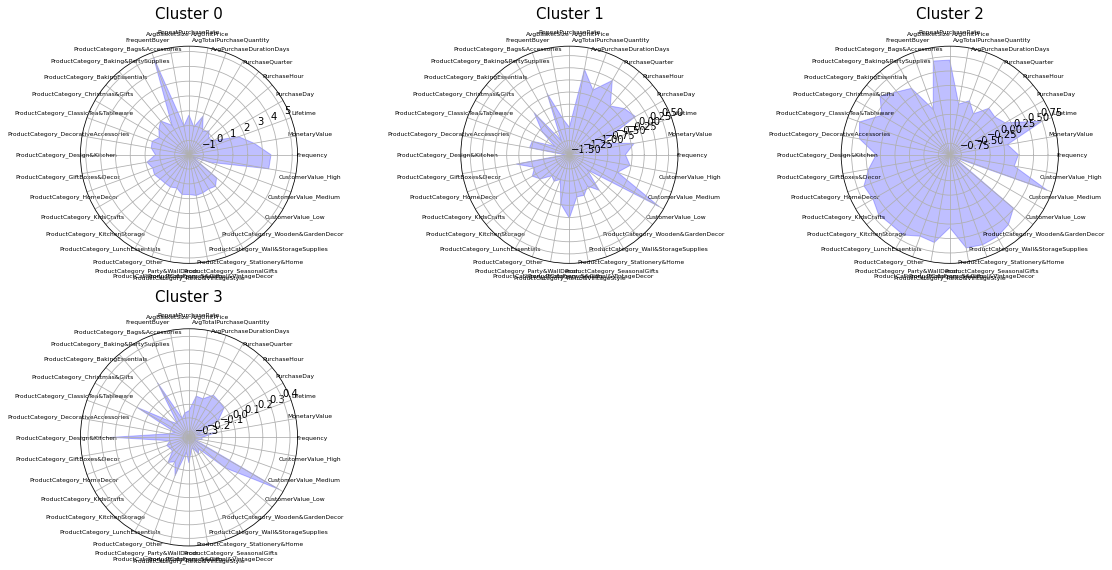

In [572]:
# Plot radar charts for each cluster (e.g., Cluster 0, Cluster 1, Cluster 2) for original dataframe
# cluster_labels = [0, 1, 2]  # Specify the cluster labels to plot

# # Scale the data (excluding the cluster column)
# scaler = StandardScaler()
# df_standard_scaled = scaler.fit_transform(df_cleaned.drop(columns=['Cluster'], axis=1))

# df_standard_scaled = pd.DataFrame(df_standard_scaled, columns=df_cleaned.columns[:-1], index=df_cleaned.index)
# df_standard_scaled['Cluster'] = df_cleaned['Cluster']

cluster_labels = [0, 1, 2, 3]  # Specify the cluster labels to plot
plot_radar_chart_subplots(df_cleaned, cluster_labels)

# plot_cluster_radar_charts(df_standard_scaled)

## 6.8 Hierarchical: Cluster Visualization - Histogram Plots

In [573]:
# Plot feature vs. clusters histogram plots for original dataframe
# plot_feature_vs_clusters(df_cleaned, df_cleaned['Cluster'])

## 6.9 Hierarchical: Random Forest Feature Selection

(4332, 37)


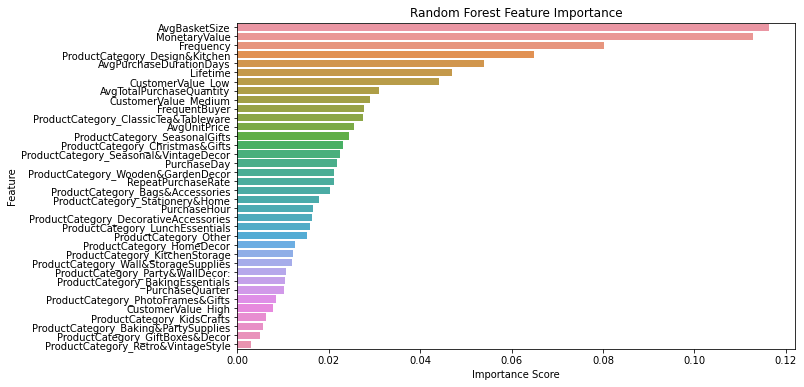

In [574]:
# Scale the data (excluding the cluster column)
print(df_cleaned.shape)
scaler = StandardScaler()
df_standard_scaled = scaler.fit_transform(df_cleaned.drop(columns=['Cluster'], axis=1))

df_standard_scaled = pd.DataFrame(df_standard_scaled, columns=df_cleaned.columns[:-1], index=df_cleaned.index)
df_standard_scaled['Cluster'] = df_cleaned['Cluster']


# Split data into features (X) and target (y)
X = df_standard_scaled.drop('Cluster', axis=1)  # Exclude the 'Cluster' column
y = df_standard_scaled['Cluster']

# Initialize Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the data
rf.fit(X, y)

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


## 6.10 Hierarchical: Random Forest Cluster Visualization - Radar Charts

Cluster 0 Features Sorted by Values:
FrequentBuyer: 5.0317
Frequency: 3.5706
MonetaryValue: 2.4993
Lifetime: 1.5970
ProductCategory_Seasonal&VintageDecor: 0.8255
AvgTotalPurchaseQuantity: 0.8069
ProductCategory_SeasonalGifts: 0.7711
RepeatPurchaseRate: 0.7148
ProductCategory_Stationery&Home: 0.6954
ProductCategory_ClassicTea&Tableware: 0.6818
ProductCategory_Wooden&GardenDecor: 0.4662
ProductCategory_Christmas&Gifts: 0.3583
ProductCategory_Bags&Accessories: 0.3386
ProductCategory_Design&Kitchen: 0.3025
AvgBasketSize: 0.0084
AvgUnitPrice: -0.0575
PurchaseDay: -0.0694
AvgPurchaseDurationDays: -0.1228
CustomerValue_Medium: -0.4919
CustomerValue_Low: -1.6319

Cluster 0 Features Sorted by Values:
MonetaryValue: 24269.8375
AvgTotalPurchaseQuantity: 1302.3690
Lifetime: 341.1127
Frequency: 31.5000
AvgBasketSize: 25.8683
AvgUnitPrice: 2.9320
PurchaseDay: 2.4155
AvgPurchaseDurationDays: 1.9087
ProductCategory_Design&Kitchen: 0.9930
RepeatPurchaseRate: 0.9930
ProductCategory_Bags&Accessories: 0.9

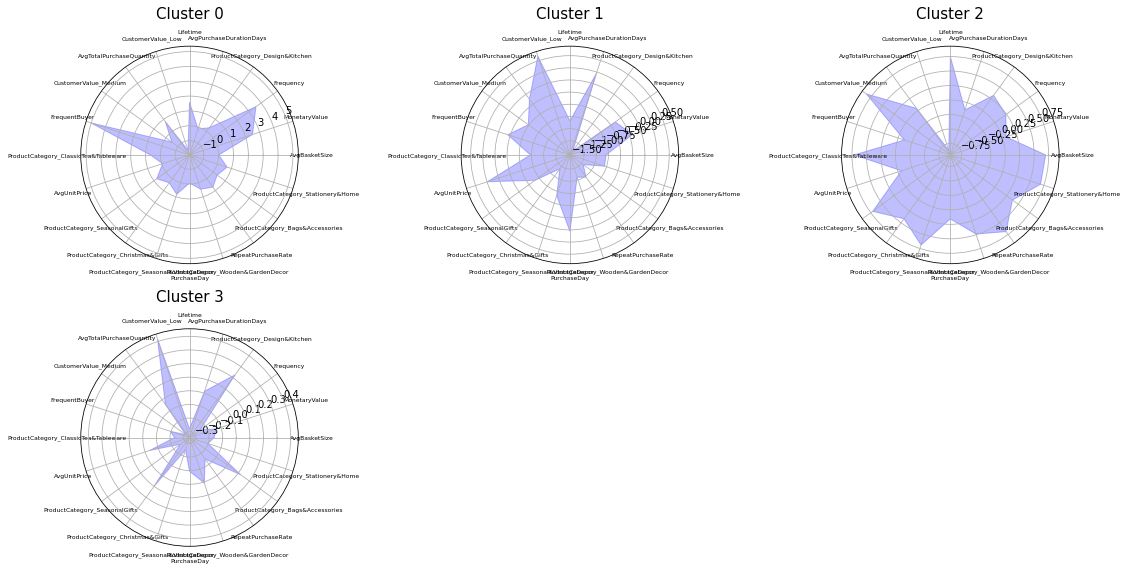

In [575]:
# Plot radar charts for each cluster (e.g., Cluster 0, Cluster 1, Cluster 2) for top 10 RF features
# Sort features by importance
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)['Feature'].tolist()

# Filter dataset to select only top features and 'Cluster' column
df_selected = df_cleaned[top_features + ['Cluster']]

cluster_labels = [0, 1, 2, 3]  # Specify the cluster labels to plot
plot_radar_chart_subplots(df_selected, cluster_labels)

## 6.11 Hierarchical: Random Forest Cluster Visualization - Histogram Plots

In [576]:
# Plot feature vs. clusters histogram plots for original dataframe
# plot_feature_vs_clusters(df_selected, df_selected['Cluster'])

## <center> 7. Gaussian Mixture Model Clustering </center>

## 7.1 GMM: Analysis on number of Clusters - Using BIC Scores

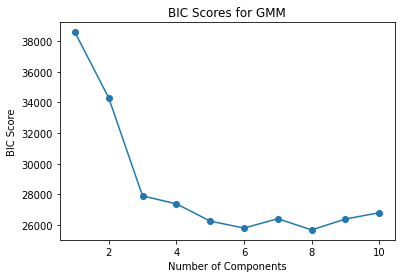

In [577]:
df_cleaned = df_cleaned.drop(columns=['Cluster'])
df_pca_components = df_pca_components.drop(columns=['Cluster'])

# Using df_pca_components for clustering, excluding the 'Cluster' column if exists
X = df_pca_components.iloc[:, :-1] if 'Cluster' in df_pca_components.columns else df_pca_components

# Split data into training and testing sets
X_train, X_test = train_test_split(X, test_size=0.25, random_state=42)

# Evaluate BIC for different number of components
n_components_range = range(1, 11)
bic_scores = []
for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X_train)
    bic_scores.append(gmm.bic(X_test))

# Plot BIC scores
plt.plot(n_components_range, bic_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('BIC Scores for GMM')
plt.show()


## 7.2 GMM: Analysis on number of Clusters - Using Elbow Method

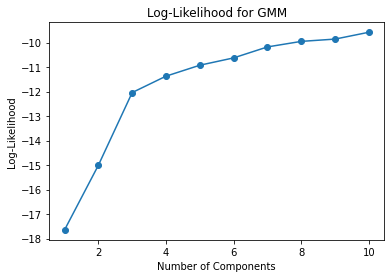

In [578]:
log_likelihoods = []
for n in range(1, 11):
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X)
    log_likelihoods.append(gmm.score(X))

plt.plot(range(1, 11), log_likelihoods, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood for GMM')
plt.show()

## 7.3 GMM Clustering
Based on both the elbow method and BIC scores, the optimal number of clusters for the dataset appears to be 5, as it shows a nearly "elbow" point and achieves the lower BIC score, indicating well-defined and separated clusters.

In [579]:
# df_cleaned = df_cleaned.drop(columns=['Cluster_x', 'Cluster_y', 'Cluster'])
# df_cleaned = df_cleaned.drop(columns=['Cluster'])
# df_pca_components = df_pca_components.drop(columns=['Cluster'])
# df_cleaned = df_cleaned.drop_duplicates()
df = df.drop_duplicates()

print(df_cleaned.shape)
print(df_pca_components.shape)
print(df.shape)

# Apply GaussianMixture clustering
clusterer = GaussianMixture(n_components=5, random_state=42)
clusterer.fit(df_pca_components)

# Analyze the clusters
labels = clusterer.predict(df_pca_components)
# (df_scaled['Cluster'] != -1)
print(labels.shape)
cluster_df = pd.DataFrame(labels, index=df_pca_components.index, columns=['Cluster'])

# 3. Evaluate cluster quality using silhouette score
silhouette_avg = silhouette_score(df_pca_components, labels)
print(f"Silhouette Score: {silhouette_avg}") 

# Combine cluster labels with the datasets
# df_cleaned['Cluster'] = cluster_df['Cluster']
df_cleaned['Cluster'] = labels
df_pca_components['Cluster'] = labels
print(df_cleaned.shape)

# Display the count of customers in each cluster
print(df_cleaned['Cluster'].value_counts())
print(df_pca_components['Cluster'].value_counts())

# Analyze cluster characteristics using descriptive statistics of features in each cluster.
cluster_means = df_cleaned.groupby('Cluster').mean()
# print(cluster_means)

(4332, 36)
(4332, 11)
(391068, 28)
(4332,)
Silhouette Score: 0.17044984312054282
(4332, 37)
2    2043
4     882
1     848
0     331
3     228
Name: Cluster, dtype: int64
2    2043
4     882
1     848
0     331
3     228
Name: Cluster, dtype: int64


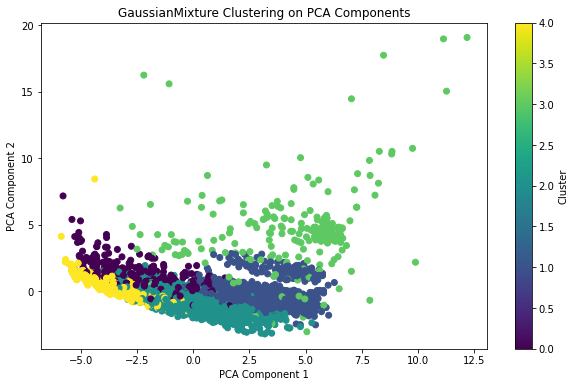

In [580]:
# Assuming the first two PCA components for visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_pca_components.iloc[:, 0], df_pca_components.iloc[:, 1], c=df_pca_components['Cluster'], cmap='viridis', label=df_pca_components['Cluster'])
plt.title('GaussianMixture Clustering on PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [581]:
df_cleaned.head(5)

Frequency  MonetaryValue  Lifetime  PurchaseDay  PurchaseHour  \
CustomerID                                                                  
17850              34        5391.21         1            3             9   
13047               9        3232.59       317            2            13   
12583              15        6705.38       370            4            12   
13748               5         948.25       278            0             9   
15100               3         876.00        40            2             9   

            PurchaseQuarter  AvgPurchaseDurationDays  \
CustomerID                                             
17850                     4                 0.000000   
13047                     2                 1.852941   
12583                     4                 1.575758   
13748                     3                10.259259   
15100                     4                19.500000   

            AvgTotalPurchaseQuantity  AvgUnitPrice  RepeatPurchaseRate  \
CustomerID                                                               
17850                      83.707071      3.960370                   1   
13047                     200.918129      3.926082                   1   
12583                     353.909483      2.140474                   1   
13748                     132.428571      3.996429                   1   
15100                      26.666667     10.950000                   1   

            AvgBasketSize  FrequentBuyer  ProductCategory_Bags&Accessories  \
CustomerID                                                                   
17850           14.414141              1                                 1   
13047           24.906433              0                                 1   
12583           16.982759              0                                 1   
13748            9.071429              0                                 0   
15100            1.000000              0                                 0   

            ProductCategory_Baking&PartySupplies  \
CustomerID                                         
17850                                          0   
13047                                          1   
12583                                          0   
13748                                          1   
15100                                          0   

            ProductCategory_BakingEssentials  ProductCategory_Christmas&Gifts  \
CustomerID                                                                      
17850                                      0                                0   
13047                                      1                                1   
12583                                      1                                1   
13748                                      0                                1   
15100                                      0                                0   

            ProductCategory_ClassicTea&Tableware  \
CustomerID                                         
17850                                          0   
13047                                          1   
12583                                          1   
13748                                          0   
15100                                          0   

            ProductCategory_DecorativeAccessories  \
CustomerID                                          
17850                                           1   
13047                                           1   
12583                                           1   
13748                                           1   
15100                                           0   

            ProductCategory_Design&Kitchen  ProductCategory_GiftBoxes&Decor  \
CustomerID                                                                    
17850                                    1                                0   
13047                                    1                                0   
12583                      

## 7.4 GMM: Visualization

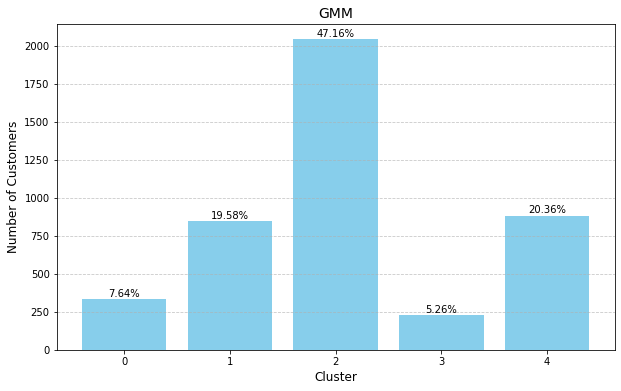

In [582]:
# Count the number of customers in each cluster
cluster_counts = df_pca_components['Cluster'].value_counts()

# Calculate the percentage of customers in each cluster
cluster_percentages = cluster_counts / len(df_pca_components) * 100

# Plotting the number of customers per cluster with percentage labels
plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')

# Adding percentage labels on top of each bar
for bar, percentage in zip(bars, cluster_percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 5, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=10)

# Adding labels and title
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.title('GMM', fontsize=14)
plt.xticks(cluster_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## 7.5 GMM: t-SNE Visualization

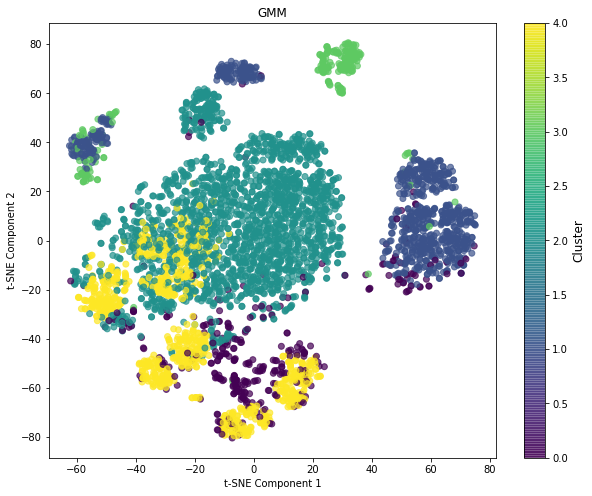

In [583]:
# Standardize the data before applying t-SNE
columns_to_scale = [col for col in df_cleaned.iloc[:, :-1].columns if col != 'CustomerID']
scaler = StandardScaler()
df_scaled = df_cleaned.iloc[:, :-1].copy()
df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])

# Apply t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=10)
# , verbose=0, perplexity=5, n_iter=300)
tsne_components = tsne.fit_transform(df_scaled)

# Extract cluster labels from df_pca_components
cluster_labels = df_cleaned['Cluster']


# Plot t-SNE components colored by cluster
plt.figure(figsize=(10, 8))
plt.scatter(tsne_components[:, 0], tsne_components[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)

plt.title('GMM')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Add color bar legend
cbar = plt.colorbar()
cbar.set_label('Cluster', fontsize=12)

plt.show()


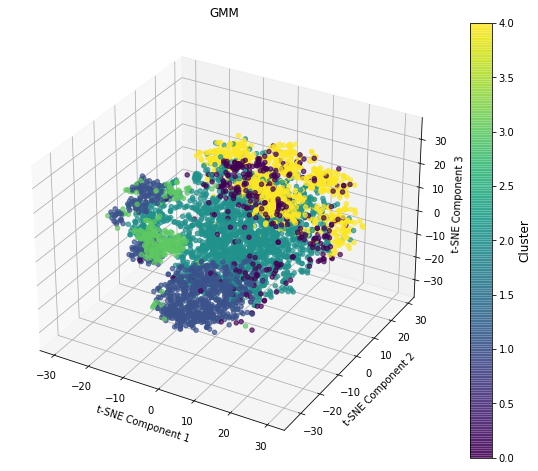

In [584]:
columns_to_scale = [col for col in df_cleaned.iloc[:, :-1].columns if col != 'CustomerID']
scaler = StandardScaler()
df_scaled = df_cleaned.iloc[:, :-1].copy()
df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])

# Extract the top 3 PCA components for visualization
# top_3_components = df_pca_components[['PC1', 'PC2', 'PC3']]

# Initialize t-SNE with 3 components and random state for reproducibility
tsne = TSNE(n_components=3, random_state=10)

# Fit t-SNE to the top 3 PCA components and transform them into a 3D space
# tsne_components = tsne.fit_transform(df_pca_components.iloc[:, :-1])
tsne_components = tsne.fit_transform(df_scaled)

# Create a 3D scatter plot of the t-SNE components colored by cluster labels
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract cluster labels from df_pca_components
cluster_labels = df_cleaned['Cluster']

# Plot t-SNE components in 3D with cluster labels as colors
scatter = ax.scatter(tsne_components[:, 0], tsne_components[:, 1], tsne_components[:, 2], c=cluster_labels, cmap='viridis', alpha=0.7)

# Add labels and title
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.set_title('GMM')

# Add color bar legend
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster', fontsize=12)

# Show the plot
plt.show()


## 7.6 GMM: Metrics Evaluation
- The silhouette score quantifies the compactness and separation of clusters. Higher values indicate better-defined clusters
- The Davies-Bouldin index evaluates the average similarity between clusters. Lower values indicate better clustering
- Inertia measures the sum of squared distances of samples to their closest cluster center. Lower inertia values indicate more compact clusters
- The Calinski-Harabasz index is a ratio of the sum of between-cluster dispersion to the sum of within-cluster dispersion. Higher values indicate better-defined, more separable clusters
- The Dunn index evaluates the compactness and separation of clusters based on intra-cluster and inter-cluster distances. Higher values indicate better clustering

In [585]:
# Compute silhouette score for clustering
silhouette_avg = silhouette_score(df_pca_components.iloc[:, :-1], df_pca_components['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

# Compute Davies-Bouldin index for clustering
db_index = davies_bouldin_score(df_pca_components.iloc[:, :-1], df_pca_components['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

# Compute Calinski-Harabasz index for clustering
ch_index = calinski_harabasz_score(df_pca_components.iloc[:, :-1], df_pca_components['Cluster'])
print(f"Calinski-Harabasz Index: {ch_index}")


Silhouette Score: 0.17044984312054282
Davies-Bouldin Index: 1.7944653595334579
Calinski-Harabasz Index: 759.680438619434


## 7.7 GMM: Cluster Visualization - Radar Charts

In [586]:
df_cleaned.head()

Frequency  MonetaryValue  Lifetime  PurchaseDay  PurchaseHour  \
CustomerID                                                                  
17850              34        5391.21         1            3             9   
13047               9        3232.59       317            2            13   
12583              15        6705.38       370            4            12   
13748               5         948.25       278            0             9   
15100               3         876.00        40            2             9   

            PurchaseQuarter  AvgPurchaseDurationDays  \
CustomerID                                             
17850                     4                 0.000000   
13047                     2                 1.852941   
12583                     4                 1.575758   
13748                     3                10.259259   
15100                     4                19.500000   

            AvgTotalPurchaseQuantity  AvgUnitPrice  RepeatPurchaseRate  \
CustomerID                                                               
17850                      83.707071      3.960370                   1   
13047                     200.918129      3.926082                   1   
12583                     353.909483      2.140474                   1   
13748                     132.428571      3.996429                   1   
15100                      26.666667     10.950000                   1   

            AvgBasketSize  FrequentBuyer  ProductCategory_Bags&Accessories  \
CustomerID                                                                   
17850           14.414141              1                                 1   
13047           24.906433              0                                 1   
12583           16.982759              0                                 1   
13748            9.071429              0                                 0   
15100            1.000000              0                                 0   

            ProductCategory_Baking&PartySupplies  \
CustomerID                                         
17850                                          0   
13047                                          1   
12583                                          0   
13748                                          1   
15100                                          0   

            ProductCategory_BakingEssentials  ProductCategory_Christmas&Gifts  \
CustomerID                                                                      
17850                                      0                                0   
13047                                      1                                1   
12583                                      1                                1   
13748                                      0                                1   
15100                                      0                                0   

            ProductCategory_ClassicTea&Tableware  \
CustomerID                                         
17850                                          0   
13047                                          1   
12583                                          1   
13748                                          0   
15100                                          0   

            ProductCategory_DecorativeAccessories  \
CustomerID                                          
17850                                           1   
13047                                           1   
12583                                           1   
13748                                           1   
15100                                           0   

            ProductCategory_Design&Kitchen  ProductCategory_GiftBoxes&Decor  \
CustomerID                                                                    
17850                                    1                                0   
13047                                    1                                0   
12583                      

Cluster 0 Features Sorted by Values:
AvgPurchaseDurationDays: 1.4706
RepeatPurchaseRate: 0.4949
CustomerValue_Medium: 0.1946
Lifetime: 0.1369
AvgUnitPrice: 0.0558
CustomerValue_Low: -0.0062
AvgTotalPurchaseQuantity: -0.0120
PurchaseDay: -0.0785
MonetaryValue: -0.1152
ProductCategory_Retro&VintageStyle: -0.1163
PurchaseHour: -0.1397
Frequency: -0.1589
PurchaseQuarter: -0.1825
FrequentBuyer: -0.1958
CustomerValue_High: -0.2834
ProductCategory_GiftBoxes&Decor: -0.3285
ProductCategory_Baking&PartySupplies: -0.3287
ProductCategory_DecorativeAccessories: -0.3620
ProductCategory_PhotoFrames&Gifts: -0.4081
ProductCategory_Wall&StorageSupplies: -0.4448
ProductCategory_Seasonal&VintageDecor: -0.4773
ProductCategory_SeasonalGifts: -0.5003
ProductCategory_Stationery&Home: -0.5217
ProductCategory_ClassicTea&Tableware: -0.5479
ProductCategory_KitchenStorage: -0.5659
ProductCategory_Wooden&GardenDecor: -0.6062
ProductCategory_HomeDecor: -0.6080
ProductCategory_KidsCrafts: -0.6106
ProductCategory_Baki

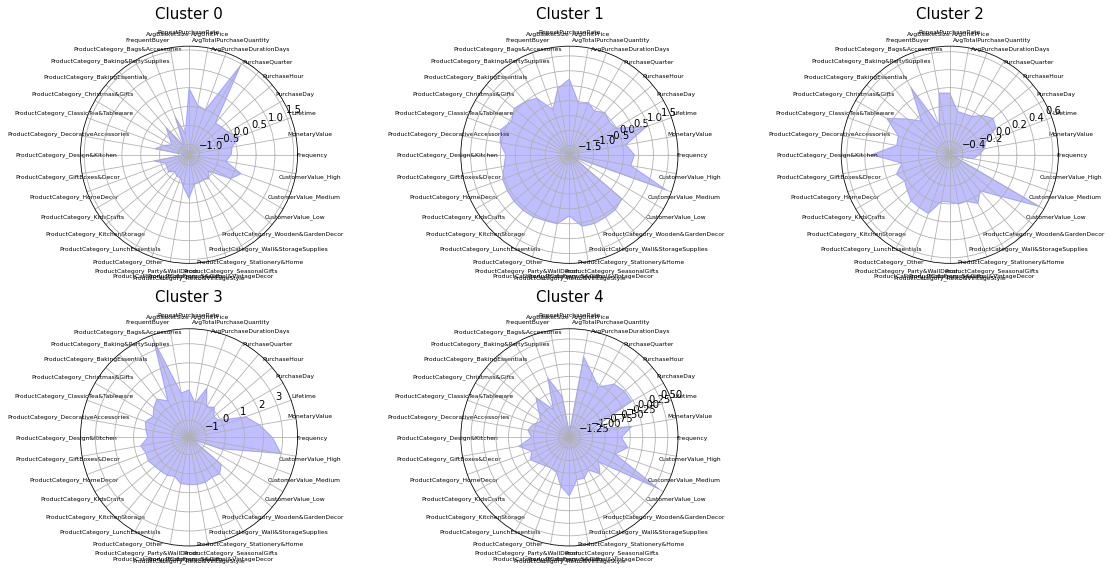

In [587]:
# Plot radar charts for each cluster (e.g., Cluster 0, Cluster 1, Cluster 2) for original dataframe
# cluster_labels = [0, 1, 2]  # Specify the cluster labels to plot

# # Scale the data (excluding the cluster column)
# scaler = StandardScaler()
# df_standard_scaled = scaler.fit_transform(df_cleaned.drop(columns=['Cluster'], axis=1))

# df_standard_scaled = pd.DataFrame(df_standard_scaled, columns=df_cleaned.columns[:-1], index=df_cleaned.index)
# df_standard_scaled['Cluster'] = df_cleaned['Cluster']

cluster_labels = [0, 1, 2, 3, 4]  # Specify the cluster labels to plot
plot_radar_chart_subplots(df_cleaned, cluster_labels)

# plot_cluster_radar_charts(df_standard_scaled)

## 7.8 GMM: Cluster Visualization - Histogram Plots

In [588]:
# Plot feature vs. clusters histogram plots for original dataframe
# plot_feature_vs_clusters(df_cleaned, df_cleaned['Cluster'])

## 7.9 GMM: Random Forest Feature Selection

(4332, 37)


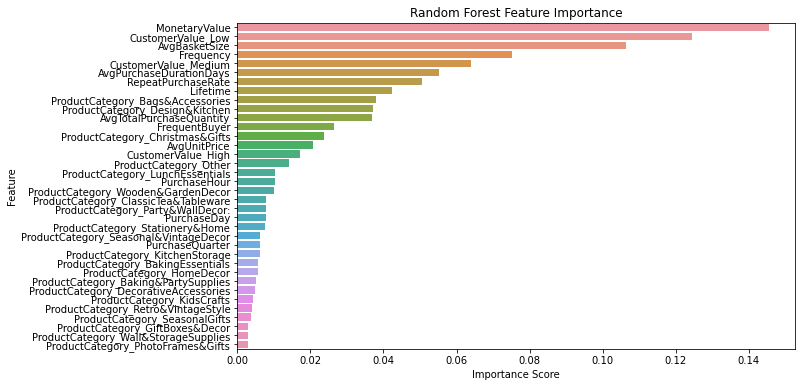

In [589]:
# Scale the data (excluding the cluster column)
print(df_cleaned.shape)
scaler = StandardScaler()
df_standard_scaled = scaler.fit_transform(df_cleaned.drop(columns=['Cluster'], axis=1))

df_standard_scaled = pd.DataFrame(df_standard_scaled, columns=df_cleaned.columns[:-1], index=df_cleaned.index)
df_standard_scaled['Cluster'] = df_cleaned['Cluster']


# Split data into features (X) and target (y)
X = df_standard_scaled.drop('Cluster', axis=1)  # Exclude the 'Cluster' column
y = df_standard_scaled['Cluster']

# Initialize Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the data
rf.fit(X, y)

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


## 7.10 GMM: Random Forest Cluster Visualization - Radar Charts

Cluster 0 Features Sorted by Values:
AvgPurchaseDurationDays: 1.4706
RepeatPurchaseRate: 0.4949
CustomerValue_Medium: 0.1946
Lifetime: 0.1369
AvgUnitPrice: 0.0558
CustomerValue_Low: -0.0062
AvgTotalPurchaseQuantity: -0.0120
MonetaryValue: -0.1152
PurchaseHour: -0.1397
Frequency: -0.1589
FrequentBuyer: -0.1958
CustomerValue_High: -0.2834
ProductCategory_ClassicTea&Tableware: -0.5479
ProductCategory_Wooden&GardenDecor: -0.6062
ProductCategory_Other: -0.6263
ProductCategory_LunchEssentials: -0.6945
AvgBasketSize: -0.7163
ProductCategory_Christmas&Gifts: -0.7453
ProductCategory_Bags&Accessories: -0.9904
ProductCategory_Design&Kitchen: -1.1486

Cluster 0 Features Sorted by Values:
MonetaryValue: 989.2521
AvgTotalPurchaseQuantity: 273.3727
Lifetime: 148.2991
AvgPurchaseDurationDays: 18.5481
PurchaseHour: 12.1722
AvgBasketSize: 8.6982
AvgUnitPrice: 3.9365
Frequency: 3.0302
RepeatPurchaseRate: 0.8882
CustomerValue_Low: 0.7281
ProductCategory_Christmas&Gifts: 0.5680
ProductCategory_Design&Kitch

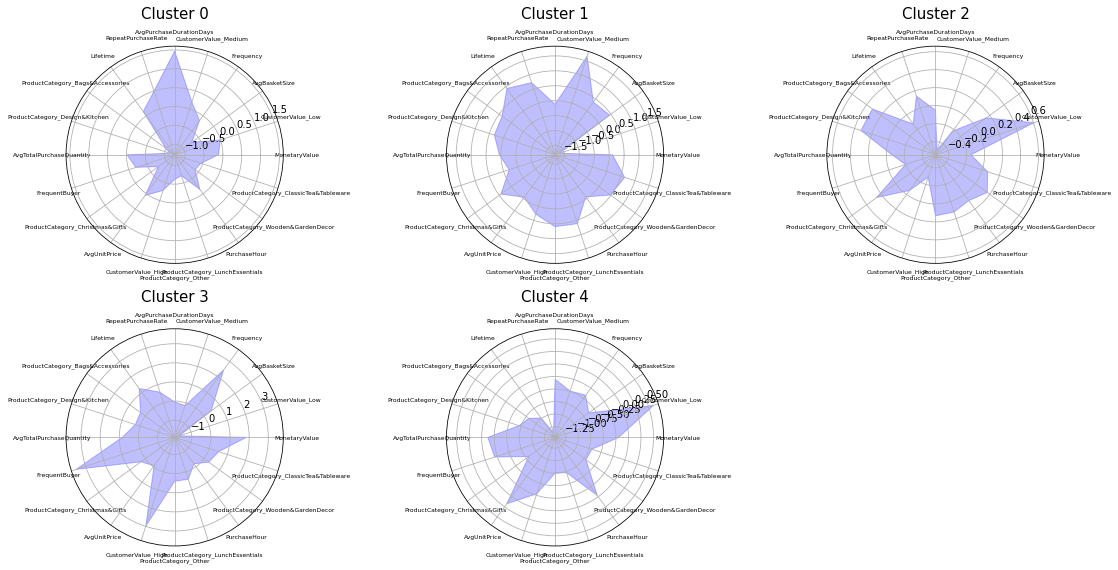

In [590]:
# Plot radar charts for each cluster (e.g., Cluster 0, Cluster 1, Cluster 2) for top 10 RF features
# Sort features by importance
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)['Feature'].tolist()

# Filter dataset to select only top features and 'Cluster' column
df_selected = df_cleaned[top_features + ['Cluster']]

cluster_labels = [0, 1, 2, 3, 4]  # Specify the cluster labels to plot
plot_radar_chart_subplots(df_selected, cluster_labels)

## 7.11 GMM: Random Forest Cluster Visualization - Histogram Plots

In [591]:
# Plot feature vs. clusters histogram plots for original dataframe
# plot_feature_vs_clusters(df_selected, df_selected['Cluster'])